# Purwadhika Final Project: Bank Marketing Campaign Analysis
by Group Beta: Anisha Ayu Putri Mayangsari, Wilson Widjaja, Vincent Tristan

> ## Background <br>

Banking businesses typically focus on managing their clients' assets, primarily cash. Apart from savings accounts, banks also offer deposit products that yield higher returns for clients who deposit their assets for a specific period. To attract existing customers to these deposit products, banks require effective marketing strategies. They often target clients who already hold savings accounts. Evaluating client profiles and deposit patterns is essential for predicting future potential clients and ensuring the efficiency of these strategies.

Currently, there is a lack of clarity regarding which customers to target for deposit account offers and any associated bonuses. This lack of clarity leads to significant operating costs due to the large customer base and target.

> ## Problem Statement <br>
Over the years, the customer base has grown, and inflation has become inevitable, impacting the balance between operational costs and revenue for businesses. To address this, the bank aims to implement strategic cost-saving measures, focusing on reducing manpower hours, including those spent on deposit marketing campaigns. While it may not be feasible to completely overhaul existing marketing methods, improving their cost-effectiveness is possible. Our challenge is to identify the top and bottom customer profiles for deposit accounts and understand the factors influencing potential customers' acceptance or rejection of marketing efforts.
The bank possesses a considerable amount of historical data on calls with potential customers and their decisions regarding marketing offers. Consequently, we aim to address the following points:

1.) Which customer profiles influence the decision to open a deposit account?

2.) How does economic conditions influence customers' decisions to invest?

> ## Goals
1.) Maximisng the reduction of cost<br>
2.) Increase revenue - by determining the appropriate strategy for each customer based on their likelihood of acceptance.

Utilizing .predict_proba to obtain probabilities (0s and 1s), incorporatinig them into an if-else structure and engaging it with scoring should based on the F1 score. We plan to provide the management with 2 types of reccomendation that they can choose from:

Defensive Approach:
- Cost reduction, a threshold of 30% is suggested; below this, strategies remain uniform.

OR
Aggressive Approach:
- Revenue increase, all customers are contacted, with strategies tailored based on probability.

Our analytical approach is to understand what kind of customer that will most likely put their deposit in our bank using Machine Learning. The initial focus on our analysis is to reduce the operational cost of calling potential customers.

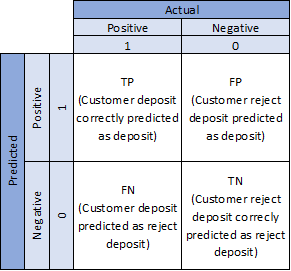

To further understand the business impact, we use the following numbers to help our calculation. In this case, we calculate our marketing cost using telemarketing method.
1. Marketing Cost (flat rate)
    - Manpower cost = EUR 7100/year/MP
    - Telco cost = EUR 240/year/telephone
    - Work hour per day = 8 hours = 480 minutes
    - Work day per year = 240 days
1. Deposit Income
    - Minimum deposit (1 year period) = EUR 2500
    - Interest rate (per annum) = 2.75%
    - Banking handling fee (per year) = EUR 70

Assume that we have 200 potential customers to call in daily basis with 10% deposit conversion rate. And the productivity to handle each potential customer is 15 minutes for each telemarketer.
This means that 1 telemarketer can handle 32 potential customers (480 minutes/15 minutes) in a day.
To reach 200 potential customers, we need 200/32 = 7 telemarketers
Each telemarketer will need 1 telephone to operate.

Meaning, the annual marketing cost total is:<br>
(7 telemarketers * EUR 7100) + (7 telephone * EUR 240) = 49700 + 1680 = EUR 51380

If we convert this to get cost per customer, we get:<br>
EUR 51380/(200 customers * 240 days) = EUR 1.07 / customer<br>

The potential income for 1 customer is:<br>
EUR 2500 - (EUR 2500 * 2.75%) + EUR 70 = EUR 2501.25 / customer

If there's daily 10% deposit conversion rate, meaning we can get 20 customers per day. If we take this numbers into a full year we get total 48000 potential customers.
- Deposit = 20 customers * 240 work days = 4800 customers
- Reject deposit = 180 customers * 240 work days = 43200 customers

---

1. This means, we waste 43200 calls in a year that is equivalent to cost of 43200*EUR 1.07 = EUR 46224.
1. However, we also have 4800 successful calls that is equivalent to income of 4800*EUR 2501.25 = EUR 12mio.

The cost tradeoff when calling all 48000 customers in a year is only EUR 46k compared to the potential revenue of EUR 12mio. If we decide to only call fewer people, there's a risk of losing a potential customer in the way. The risk of losing 1 customer is EUR 2501.25 compared to the risk of calling 1 customer who reject the deposit which is EUR 1.07.

Thus, by this calculation, it is more preferable to use the metric **F1 score** and focus on both reduce the number of False Negative & False Positive, to ensure we get the maximum revenue. It creates the flexibility for our marketing head to use defensive or aggresive strategy for calling potential customers.

\begin{equation}
F1 Score=2*\frac{Recall * Precision}{Recall + Precision}
\end{equation}

---

Source data:
- [MP Cost](https://worldsalaries.com/average-telephone-operator-salary-in-portugal/)
- [Telephone cost](https://bestplacesintheworldtoretire.com/questions-and-answers/portugal/portuguese-republic/portugal-cost-of-living/how-much-does-it-cost-to-get-landline-phone-service-in-portugal/)
- [Interest rate calculation](https://clientebancario.bportugal.pt/en/interest-rates)
- [Minimum deposit](https://www.bancomontepio.pt/en/individuals/savings-and-retirement/term-deposits)
- [Monthly handling](https://www.portugalbuyersagent.com/banking-in-portugal/#:~:text=Most%20Portuguese%20bank%20accounts%20charge,such%20as%20student%20bank%20accounts).

---

> ## Data Preparing and Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, skew, kurtosis

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = 'bank-additional-full.csv'
df = pd.read_csv(file_path, delimiter=';')
display(df.head(),df.tail())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [3]:
print(f'Total number of rows and columns in the dataset are {df.shape}')
df.info()

Total number of rows and columns in the dataset are (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.i

In [4]:
display(df.describe(), df.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,78,"[56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 5..."
1,job,12,"[housemaid, services, admin., blue-collar, tec..."
2,marital,4,"[married, single, divorced, unknown]"
3,education,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,3,"[no, unknown, yes]"
5,housing,3,"[no, yes, unknown]"
6,loan,3,"[no, yes, unknown]"
7,contact,2,"[telephone, cellular]"
8,month,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
9,day_of_week,5,"[mon, tue, wed, thu, fri]"


> ## Data Understanding Summary

To summarize, we can observe that:

- The Bank Marketing Campaign dataset has 21 columns and 41,188 rows.
- None of the columns in the dataset have any missing values.
- Due to each column having not having an eniterly unique value (e.g transaction IDs, License Number, etc.), we will be using all the data and no data will be deleted inittially.

Let's investigate further and move to the cleaning process.

## Data Cleaning

We will now handle a big anomaly of our dataset which is the missing values.

In [6]:
#loan yes and default unknown=delete

df = df[~((df['loan'] == 'yes') & (df['default'] == 'unknown'))]

#loan no and default unknown

# Updating 'default' to 'no' where 'loan' is 'no' and 'default' is 'unknown'
df.loc[(df['loan'] == 'no') & (df['default'] == 'unknown'), 'default'] = 'no'

# Display DataFrame after updating values
print(df.head())

   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   
1         mon  ...         1    999         0  nonexistent          1.1   
2         mon  ...         1    999         0  nonexistent          1.1   
3         mon  ...         1    999         0  nonexistent          1.1   
4         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  

In [7]:
#unknown percentage in loan

# Assuming 'df' is your DataFrame
# Check if "unknown" is present in specific rows of a specific column
specific_rows_with_unknown = df[df['loan'].str.contains('unknown', na=False)]

# Calculate the percentage of "unknown" values
total_non_null = df['loan'].notnull().sum()
percent_unknown = (specific_rows_with_unknown.shape[0] / total_non_null) * 100

# Display the rows where "unknown" is found
print("Rows with 'unknown' in loan Column:")
print(specific_rows_with_unknown)

# Display the percentage of "housing" values
print("\nPercentage of 'unknown' values in the loan column: {:.2f}%".format(percent_unknown))

# Delete the rows where "unknown" is found
df = df[~df['housing'].str.contains('unknown', na=False)]

# Display the DataFrame after deleting rows with "unknown"
print("\nDataFrame after deleting rows with 'unknown':")
print(df.head())


Rows with 'unknown' in loan Column:
       age          job   marital            education  default  housing  \
29      55      unknown   married    university.degree  unknown  unknown   
81      51  blue-collar   married             basic.4y  unknown  unknown   
261     27  blue-collar    single             basic.6y       no  unknown   
385     59   management   married             basic.4y  unknown  unknown   
401     48     services   married          high.school  unknown  unknown   
...    ...          ...       ...                  ...      ...      ...   
40990   31       admin.    single    university.degree       no  unknown   
41014   31   technician    single  professional.course       no  unknown   
41015   34       admin.  divorced    university.degree       no  unknown   
41029   46   management   married    university.degree       no  unknown   
41115   42     services  divorced    university.degree       no  unknown   

          loan    contact month day_of_week  ...  c

In [8]:
#unknown percentage in housing

# Assuming 'df' is your DataFrame
# Check if "unknown" is present in specific rows of a specific column
specific_rows_with_unknown = df[df['housing'].str.contains('unknown', na=False)]

# Calculate the percentage of "unknown" values
total_non_null = df['housing'].notnull().sum()
percent_unknown = (specific_rows_with_unknown.shape[0] / total_non_null) * 100

# Display the rows where "unknown" is found
print("Rows with 'unknown' in housing Column:")
print(specific_rows_with_unknown)

# Display the percentage of "housing" values
print("\nPercentage of 'unknown' values in the housing column: {:.2f}%".format(percent_unknown))
#2.41
#print(df.head())

# Delete the rows where "unknown" is found
df = df[~df['housing'].str.contains('unknown', na=False)]

# Display the DataFrame after deleting rows with "unknown"
print("\nDataFrame after deleting rows with 'unknown':")
print(df.head())

Rows with 'unknown' in housing Column:
Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y]
Index: []

[0 rows x 21 columns]

Percentage of 'unknown' values in the housing column: 0.00%

DataFrame after deleting rows with 'unknown':
   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1  

In [9]:
#unknown percentage in marital

# Assuming 'df' is your DataFrame
# Check if "unknown" is present in specific rows of a specific column
specific_rows_with_unknown = df[df['marital'].str.contains('unknown', na=False)]

# Calculate the percentage of "unknown" values
total_non_null = df['marital'].notnull().sum()
percent_unknown = (specific_rows_with_unknown.shape[0] / total_non_null) * 100

# Display the rows where "unknown" is found
print("Rows with 'unknown' in Marital Column:")
print(specific_rows_with_unknown)

# Display the percentage of "unknown" values
print("\nPercentage of 'unknown' values in the Marital column: {:.2f}%".format(percent_unknown))
# percentage of unknown in marital column is less than 30%, we will continue to delete columns with unknown

# Delete the rows where "unknown" is found
df = df[~df['marital'].str.contains('unknown', na=False)]

# Display the DataFrame after deleting rows with "unknown"
print("\nDataFrame after deleting rows with 'unknown':")
print(df.head())

Rows with 'unknown' in Marital Column:
       age           job  marital          education default housing loan  \
40      58    management  unknown  university.degree      no     yes   no   
390     59       retired  unknown  university.degree      no      no   no   
413     57       retired  unknown           basic.4y      no      no   no   
1493    33      services  unknown        high.school      no     yes  yes   
1608    32       unknown  unknown  university.degree      no      no   no   
...    ...           ...      ...                ...     ...     ...  ...   
38550   31  entrepreneur  unknown  university.degree      no      no   no   
38579   31  entrepreneur  unknown  university.degree      no     yes   no   
39322   30    technician  unknown  university.degree      no      no   no   
39323   30    technician  unknown  university.degree      no      no   no   
40857   30    technician  unknown  university.degree      no      no   no   

         contact month day_of_week  

In [10]:
#unknown percentage in education

# Assuming 'df' is your DataFrame
# Check if "unknown" is present in specific rows of a specific column
specific_rows_with_unknown = df[df['education'].str.contains('unknown', na=False)]

# Calculate the percentage of "unknown" values
total_non_null = df['education'].notnull().sum()
percent_unknown = (specific_rows_with_unknown.shape[0] / total_non_null) * 100

# Display the rows where "unknown" is found
print("Rows with 'unknown' in Education Column:")
print(specific_rows_with_unknown)

# Display the percentage of "unknown" values
print("\nPercentage of 'unknown' values in the Education column: {:.2f}%".format(percent_unknown))
# percentage of unknown in marital column is less than 30%, we will continue to delete columns with unknown

# Delete the rows where "unknown" is found
df = df[~df['education'].str.contains('unknown', na=False)]

# Display the DataFrame after deleting rows with "unknown"
print("\nDataFrame after deleting rows with 'unknown':")
print(df.head())

Rows with 'unknown' in Education Column:
       age          job  marital education default housing loan    contact  \
7       41  blue-collar  married   unknown      no      no   no  telephone   
10      41  blue-collar  married   unknown      no      no   no  telephone   
26      59   technician  married   unknown      no     yes   no  telephone   
30      46       admin.  married   unknown      no      no   no  telephone   
31      59   technician  married   unknown      no     yes   no  telephone   
...    ...          ...      ...       ...     ...     ...  ...        ...   
41118   34   technician  married   unknown      no     yes   no   cellular   
41120   60       admin.  married   unknown      no      no   no   cellular   
41122   34   technician  married   unknown      no      no   no   cellular   
41135   54   technician  married   unknown      no     yes   no   cellular   
41175   34      student   single   unknown      no     yes   no   cellular   

      month day_of_wee

In [11]:
#unknown percentage in job

# Assuming 'df' is your DataFrame
# Check if "unknown" is present in specific rows of a specific column
specific_rows_with_unknown = df[df['job'].str.contains('unknown', na=False)]

# Calculate the percentage of "unknown" values
total_non_null = df['job'].notnull().sum()
percent_unknown = (specific_rows_with_unknown.shape[0] / total_non_null) * 100

# Display the rows where "unknown" is found
print("Rows with 'unknown' in job Column:")
print(specific_rows_with_unknown)

# Display the percentage of "unknown" values
print("\nPercentage of 'unknown' values in the job column: {:.2f}%".format(percent_unknown))
# percentage of unknown in marital column is less than 30%, we will continue to delete columns with unknown

# Delete the rows where "unknown" is found
df = df[~df['job'].str.contains('unknown', na=False)]

# Display the DataFrame after deleting rows with "unknown"
print("\nDataFrame after deleting rows with 'unknown':")
print(df.head())

Rows with 'unknown' in job Column:
       age      job   marital            education default housing loan  \
35      55  unknown   married             basic.4y      no     yes   no   
144     38  unknown  divorced          high.school      no     yes   no   
794     28  unknown    single             basic.9y      no      no   no   
878     28  unknown    single             basic.9y      no     yes   no   
885     43  unknown   married          high.school      no      no   no   
...    ...      ...       ...                  ...     ...     ...  ...   
40058   57  unknown   married             basic.4y      no     yes   no   
40208   54  unknown   married             basic.9y      no     yes   no   
40240   42  unknown    single    university.degree      no      no   no   
40244   42  unknown    single    university.degree      no     yes   no   
41005   63  unknown   married  professional.course      no      no   no   

         contact month day_of_week  ...  campaign  pdays  previo

---

### Checking Outlier

For our further analysis, we need to determine that we used the appropriate metrics for analysis. We want to see if it's more proper to use mean or median in our analysis.

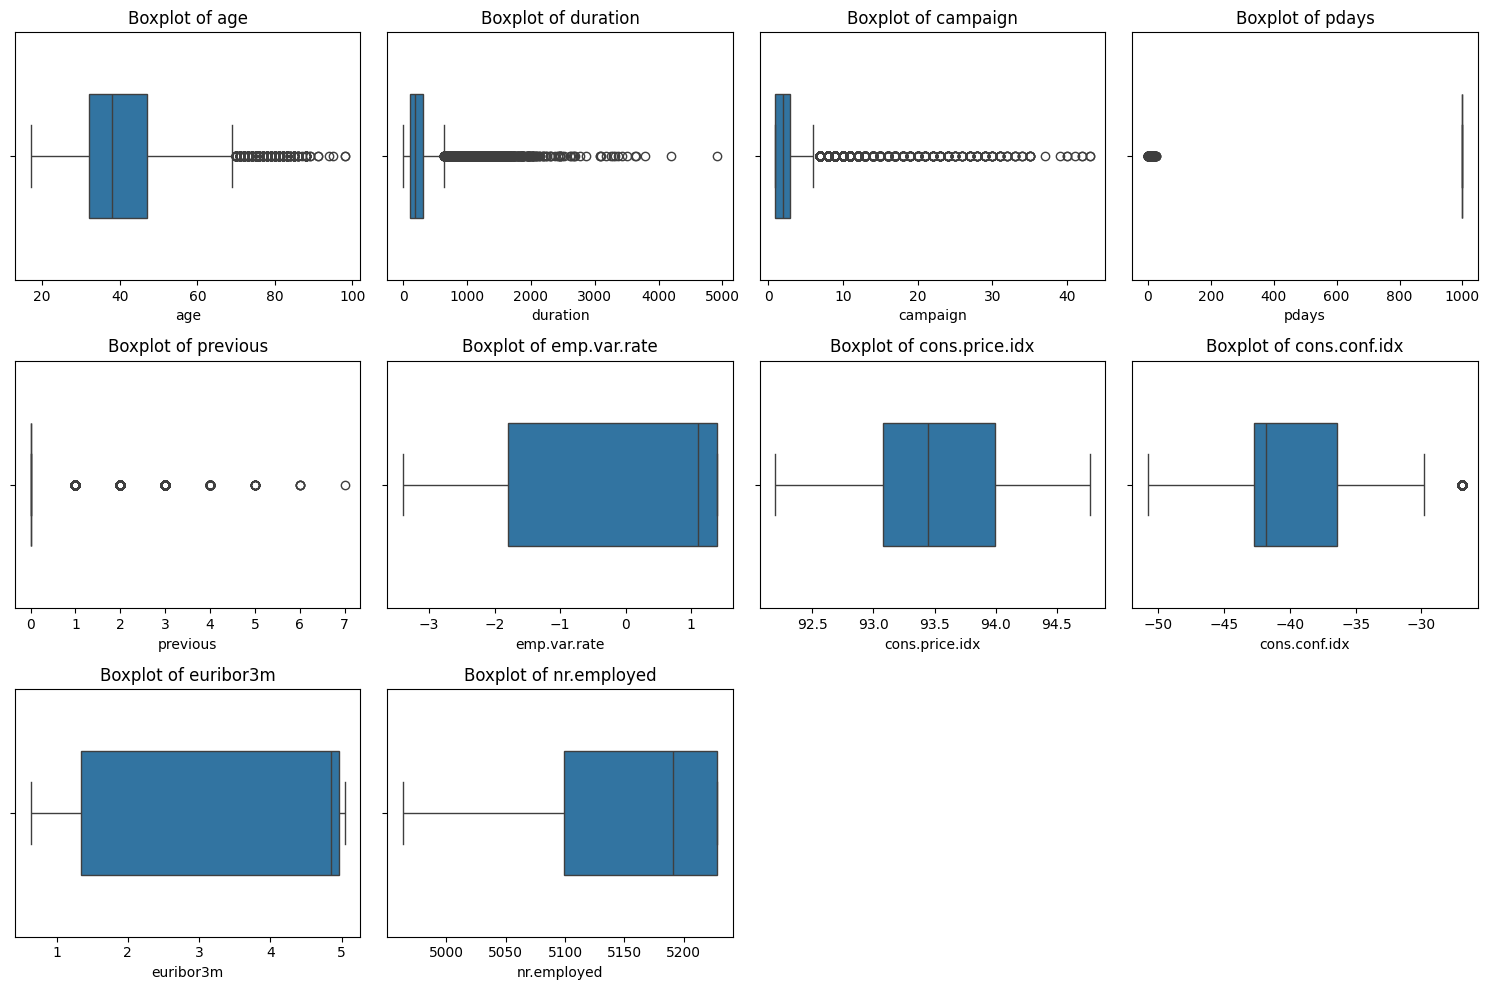

In [12]:
# Analyzing boxplots to determine whether there are outliers and how to handle them

numerical_columns = ['age', 'duration', 'campaign','pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
plt.figure(figsize=(15, 10))  
for i, var in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)  
    sns.boxplot(x=df[var], orient='v', width=0.5)  
    plt.title(f'Boxplot of {var}')  
    plt.tight_layout() 
plt.show() 

In [13]:
numcolumns = df.select_dtypes(exclude=['object', 'category']).columns
print(numcolumns)
print(len(numcolumns))

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
10


In [14]:
desc_age = df["age"].describe()
desc_duration = df["duration"].describe()
desc_campaign = df["campaign"].describe()
desc_pdays = df["pdays"].describe()
desc_previous = df["previous"].describe()
desc_emp = df["emp.var.rate"].describe()
desc_consprice = df["cons.price.idx"].describe()
desc_consconf = df["cons.conf.idx"].describe()
desc_eur = df["euribor3m"].describe()
desc_nr = df["nr.employed"].describe()

desc_list = [desc_age, desc_duration, desc_campaign, desc_pdays, desc_previous, desc_emp, desc_consprice, 
            desc_consconf, desc_eur, desc_nr]

In [15]:
#function for check outlier
def outlier_check(col,x):   
    Q1 = col["25%"]
    Q3 = col["75%"]

    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)

    outliers = df[(df[x] > upper_limit) | (df[x] < lower_limit)].value_counts().sum()
    original = df[x].value_counts().sum()
    percentage_outliers = outliers / original * 100
    return percentage_outliers

In [16]:
outlier = []
outlier_word = []
for i, j in zip(desc_list, numcolumns):
    if outlier_check(i, j) == 0:
        outlier_word.append("No Outliers")
        outlier.append(outlier_check(i, j))
    else:
        outlier_word.append("Have Outliers")
        outlier.append(outlier_check(i, j))
        
outlier_table = pd.DataFrame({"Outliers" : outlier, "Meaning" : outlier_word}, index = numcolumns)

outlier_table

,Outliers,Meaning
age,1.101096,Have Outliers
duration,7.170616,Have Outliers
campaign,5.783451,Have Outliers
pdays,3.659524,Have Outliers
previous,13.769094,Have Outliers
emp.var.rate,0.000000,No Outliers
cons.price.idx,0.000000,No Outliers
cons.conf.idx,1.095698,Have Outliers
euribor3m,0.000000,No Outliers
nr.employed,0.000000,No Outliers


Based on the dataset, we can see that there's several outlier data from 6 variables as mentioned above. We decided to keep all the outliers as the dataset is taken from actual potential client data.

---

In [17]:
##Duplicates

duplicate_rows = df[df.duplicated()]

# Display duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

# Remove duplicates
df = df.drop_duplicates()

# Optionally, verify that duplicates have been removed
print("\nAfter removing duplicates:")
print(df.head())  # Display first few rows of cleaned DataFrame

# PROBLEM FOUND: NO speicif id is found so we are unsure if the duplictaes are actualy duplicates or different poepl with the same exact [atterns and outcoems]

Duplicate Rows:
       age          job   marital            education default housing loan  \
1266    39  blue-collar   married             basic.6y      no      no   no   
5664    56  blue-collar   married             basic.4y      no      no   no   
14234   27   technician    single  professional.course      no      no   no   
16956   47   technician  divorced          high.school      no     yes   no   
18465   32   technician    single  professional.course      no     yes   no   
19608   33       admin.   married    university.degree      no     yes   no   
20216   55     services   married          high.school      no      no   no   
20534   41   technician   married  professional.course      no     yes   no   
25217   39       admin.   married    university.degree      no      no   no   
28477   24     services    single          high.school      no     yes   no   
32516   35       admin.   married    university.degree      no     yes   no   
36951   45       admin.   married   

### Grouping Data for EDA

The data we're going to group are the potential customer profile that aligns with our business question. The data is grouped to ease data analysis to see each variable correlation with the customer's decision.

1. Age Group: based on the chronological age that is divided into 4 categories. This time period marks the transition into adulthood that is characterized by important life events such as education, having a family, or financial stability.
     - 0 - 19 y.o: Under 20
     - 20 - 39 y.o: Young Adult
     - 40 - 59 y.o: Middle aged Adult
     - More than 60: Senior Citizen
    - Source: [Age Grouping](https://www.sciencedirect.com/topics/computer-science/chronological-age)
1. Economic Variables: grouping based on dataset median, into low class and high class.
    - emp.var.rate
    - cons.price.idx
    - cons.conf.idx
    - euribor3m
    - nr.employed


In [18]:
#grouping datas

# grouping age groups

bins = [0, 19, 39, 59, 100]  # Define age bins as needed
labels = ['Under 20', 'Young Adults', 'Middle-aged Adults', 'Senior Citizens']  # Define labels for age groups

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new age group column
print(df.head())

   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  pdays  previous     poutcome  emp.var.rate cons.price.idx  \
0         mon  ...    999         0  nonexistent           1.1         93.994   
1         mon  ...    999         0  nonexistent           1.1         93.994   
2         mon  ...    999         0  nonexistent           1.1         93.994   
3         mon  ...    999         0  nonexistent           1.1         93.994   
4         mon  ...    999         0  nonexistent           1.1         93.994   

   cons.conf.idx  euribor3

In [19]:
# grouping economical influences
# we will be categorizing all economical influences to low and high
# low = min to median value
# high = median to max value

#Emp.var.rate
bins = [-4, 1.1, 2 ] # Define duration bins as needed
labels = ['Low Emp.var.rate', 'High Emp.var.rate']  # Define labels for duration groups

df['Emp.var.rate_group'] = pd.cut(df['emp.var.rate'], bins=bins, labels=labels, right=False)

#Cons.price.idx
bins = [92, 93.749, 95] # Define duration bins as needed
labels = ['Low Cons.price.idx', 'High Cons.price.idx']  # Define labels for duration groups

df['Cons.price.idx_group'] = pd.cut(df['cons.price.idx'], bins=bins, labels=labels, right=False)

#Cons.conf.idx
bins = [-51,-41.8,-25] # Define duration bins as needed
labels = ['Low Cons.conf.idx', 'High Cons.conf.idx']  # Define labels for duration groups

df['Cons.conf.idx_group'] = pd.cut(df['cons.conf.idx'], bins=bins, labels=labels, right=False)

#Euribor3m
bins = [0.5,4.857,6] # Define duration bins as needed
labels = ['Low Euribor3m', 'High Euribor3m']  # Define labels for duration groups

df['Euribor3m_group'] = pd.cut(df['euribor3m'], bins=bins, labels=labels, right=False)

#Nr.employed
bins = [4000,5191,6000] # Define duration bins as needed
labels = ['Low Nr.employed', 'High Nr.employed']  # Define labels for duration groups

df['Nr.employed'] = pd.cut(df['nr.employed'], bins=bins, labels=labels, right=False)


# Display the DataFrame with the new age group column
print(df.head())

   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  cons.conf.idx  euribor3m  nr.employed   y  \
0         mon  ...          -36.4      4.857       5191.0  no   
1         mon  ...          -36.4      4.857       5191.0  no   
2         mon  ...          -36.4      4.857       5191.0  no   
3         mon  ...          -36.4      4.857       5191.0  no   
4         mon  ...          -36.4      4.857       5191.0  no   

            age_group  Emp.var.rate_group  Cons.price.idx_group  \
0  Middle-aged Adults   High Emp.var.rate   High Cons.p

In [20]:
# Get the columns with unknown values
columns_with_unknown = df.columns[df.isin(['unknown']).any()]

# Display the columns with unknown values
print("Columns with 'unknown' values:")
print(columns_with_unknown)

#this formula is used to check fi unknonw is still in the dataset or not


Columns with 'unknown' values:
Index([], dtype='object')


> ## Cleaned Data

In [21]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'missing values', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(37041, 27)


,dataFeatures,dataType,missing values,unique,uniqueSample
0,age,int64,0,77,"[18, 59]"
1,job,object,0,11,"[entrepreneur, admin.]"
2,marital,object,0,3,"[divorced, single]"
3,education,object,0,7,"[basic.6y, university.degree]"
4,default,object,0,2,"[yes, no]"
5,housing,object,0,2,"[no, yes]"
6,loan,object,0,2,"[no, yes]"
7,contact,object,0,2,"[cellular, telephone]"
8,month,object,0,10,"[may, apr]"
9,day_of_week,object,0,5,"[wed, fri]"


Before the cleaning, we had 41,188 rows of data and now we have 37,041 rows of data. 

Not to mention, we started with 21 columns but have now ended up with 27 because we added 7 columns 'age_group', 'Emp.var.rate_group', 'Cons.price.idx_group', 'Cons.conf.idx_group', 'Euribor3m_group' and 'Nr.employed'.



In [24]:
df.to_csv('cleaned_data_BMC_update1.csv', index=False)

---

> ## Exploratory Data Analysis

### Question 1: What kind of customer profile that influence the result to put deposit?
We want to see in details on what kind of variables do we have along with its numbers. We can have a sense of how diverse our data is then we can see its correlation to our target column (y) and see what type of customers that mostly put deposit.

Our variables for categorical data are job, marital, education, default, housing, loan, contact, month, day of week, age group & duration group

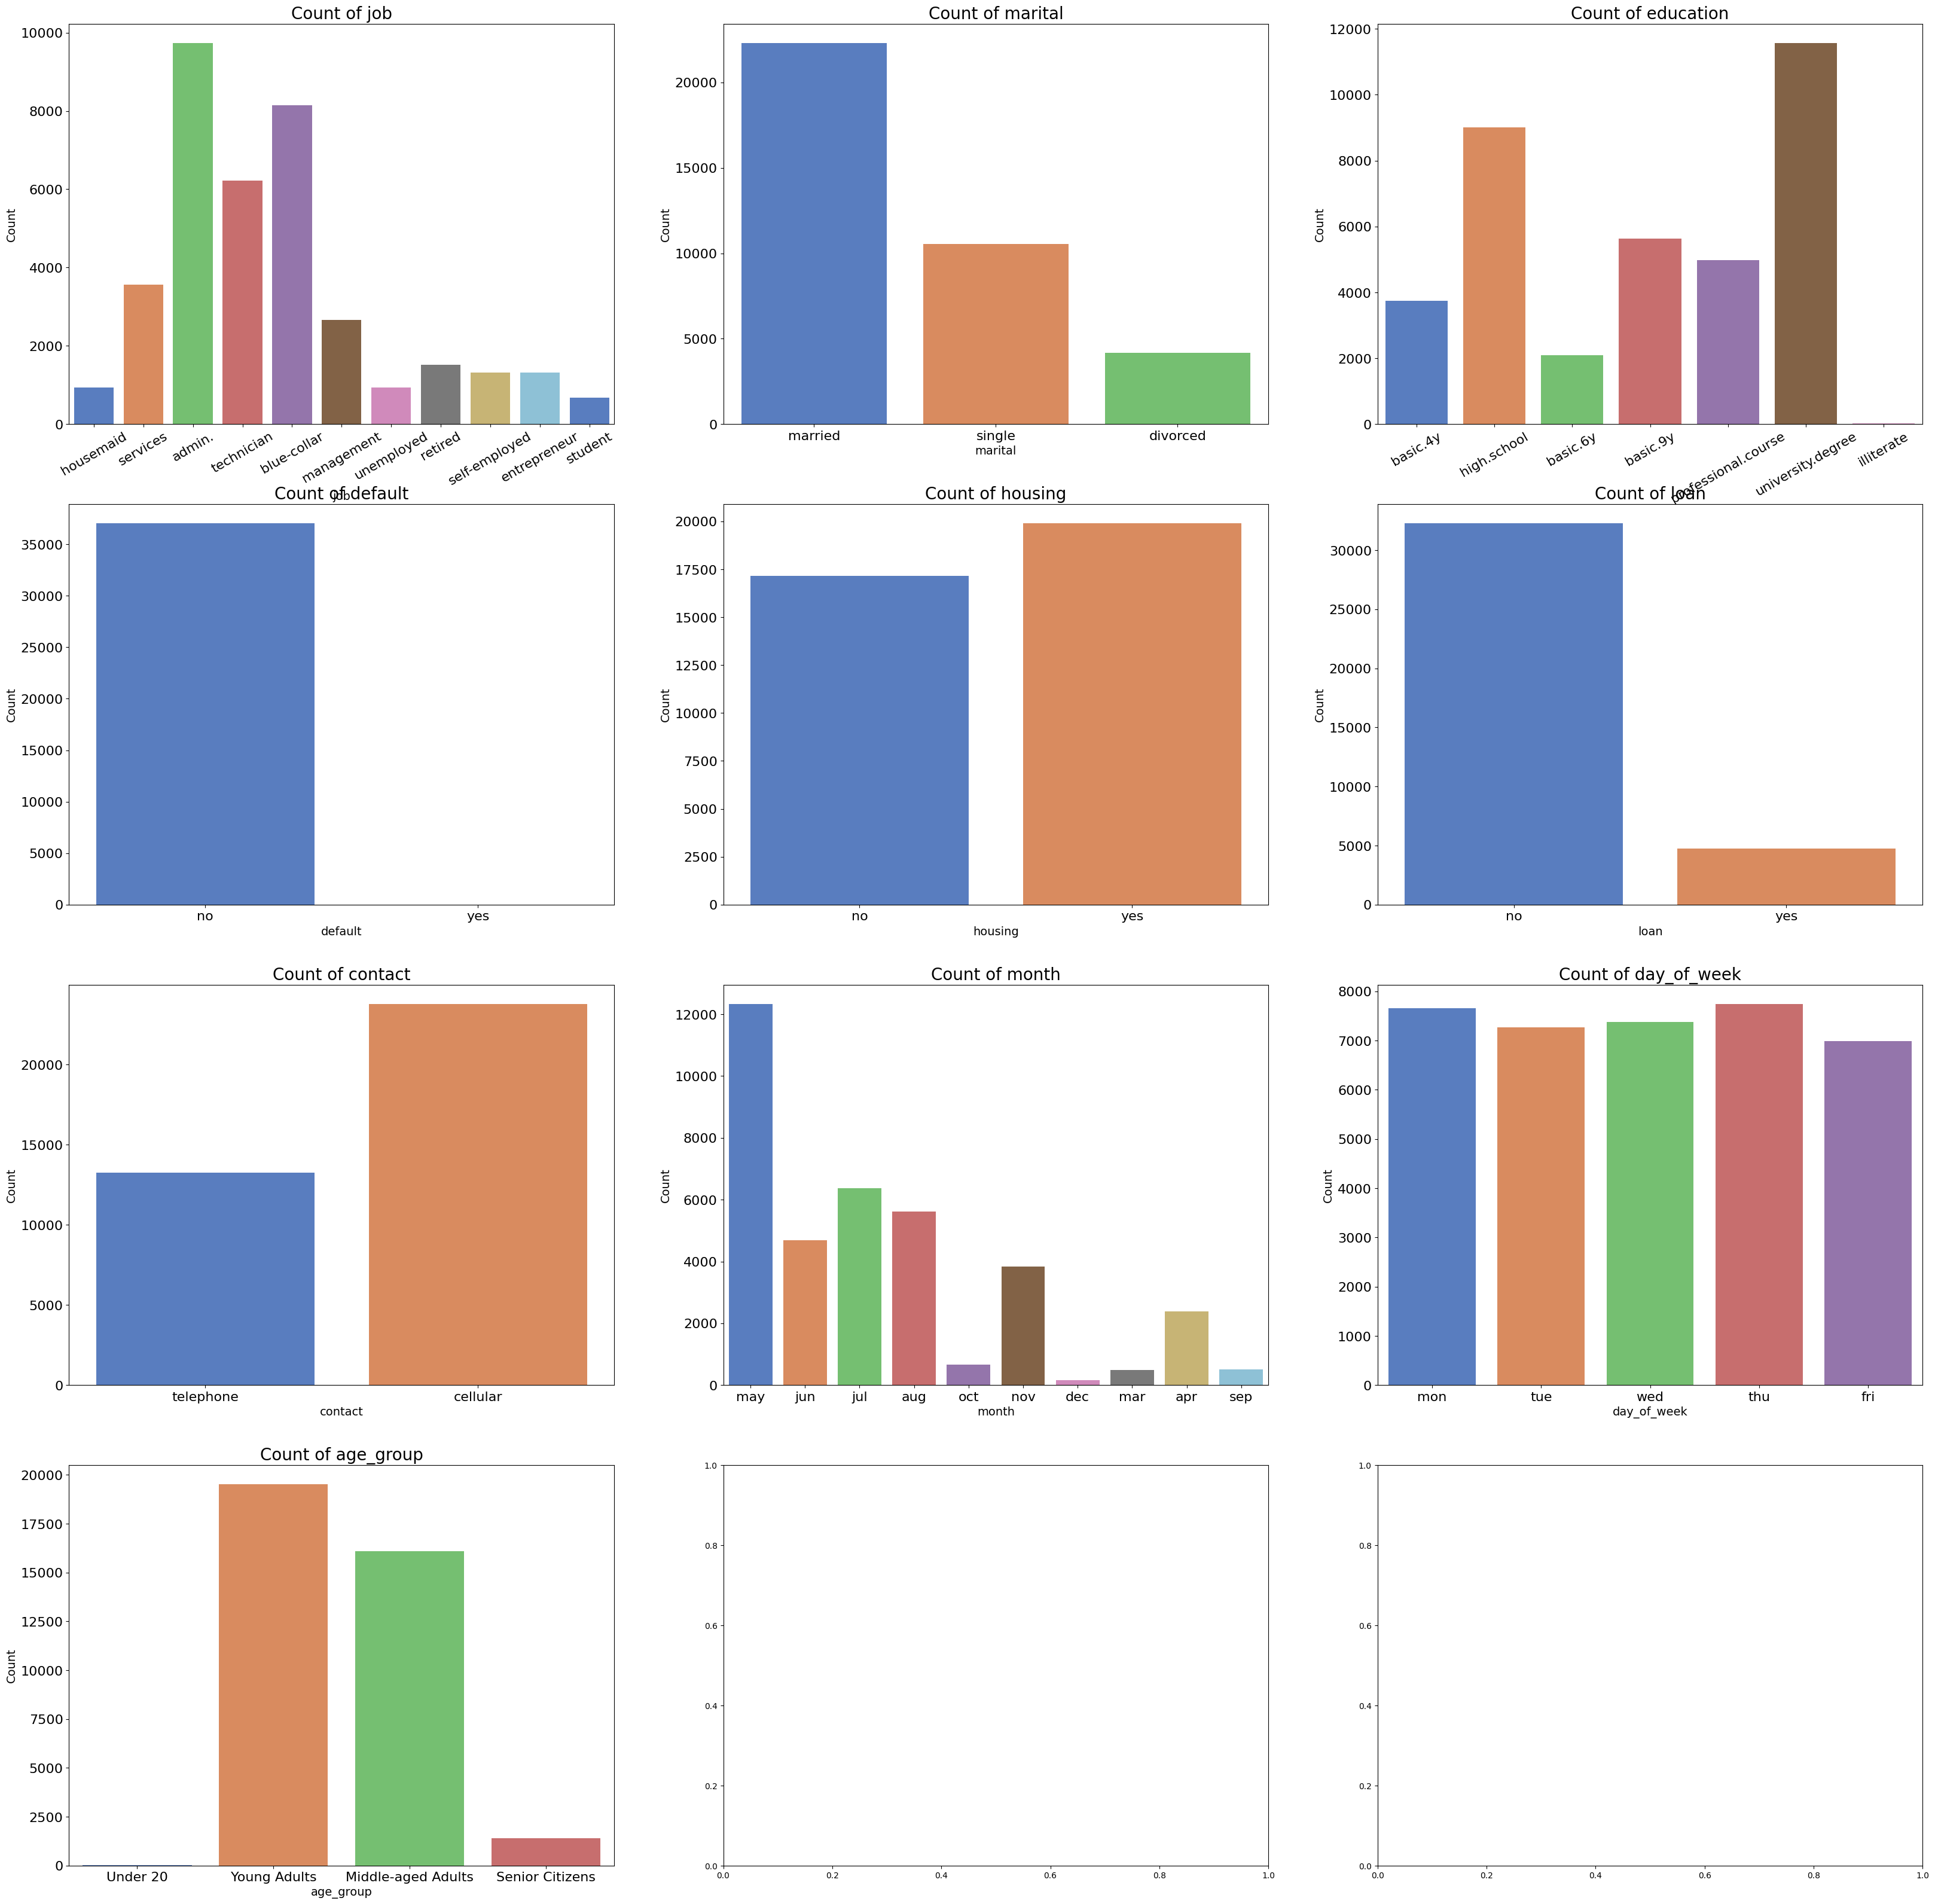

In [22]:
var = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'age_group']
fig, axes = plt.subplots(4,3, figsize=(40,40))

for ax, i in zip(axes.flatten(), var):
    sns.countplot(data=df, x=i, ax=ax, palette='muted')
    ax.set_title('Count of '+ i, fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(i, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    if i in ('job', 'education'):
        ax.tick_params(axis='x', rotation=30)

Based on our findings above, we can see that:
1. Job: 11 categories (housemaid, services, admin, blue-collar, technician, retired, management, unemployed, self-employed, entrepreneur, student)
    - Our dataset contains multiple job from lower class income (e.g. student) into higher class income (e.g. management)
    - The job is varied and not only containing from specific economic class
    - The majority of jobs in our dataset consist of administrative roles, blue-collar positions, and technicians
1. Marital: 3 categories (married, single, divorced)
    - This dataset covers all of marital categories but most people are married
    - In a way, it makes sense since married couples are adult that are more likely to have a bank account compared to younger people
1. Education: 8 categories (basic 4y, basic 6y, basic 9y, high school, university degree, professional course, illiterate)
    - The dataset contains various people with different type of education, including illiterate
    - The majority of education are university degree, highschool, and basic 9y. This explains that most of the bank customer are educated people
1. Default: 2 categories (yes, no)
    - Bank customers are usually people who wanted to save their money, so it makes sense that the majority people in our dataset didn't have any credit
1. Housing: 2 categories (yes, no)
    - Most of people in our dataset have housing property
1. Loan: 2 categories (yes, no)
    - Similar with default, most people who owns money to save don't have any loan to pay off.
1. Contact: 2 categories (telephone, cellular)
    - Most people are contacted on their cellular since it is uncommon to be contacted with telephone except for work or home phone.
1. Month: 10 categories (mar - dec)
    - Interestingly, most people in our dataset were contacted in the month of May.
    - We can explore this fact to see why May is the time to do the phone campaign
1. Day of week: 5 categories (mon - fri)
    - We can see that the count on each category is similar except for Friday.
    - Friday is the last working day that may be the reason on why several people not picking up their call
1. Age group: 4 categories (under 20, young adults, middle aged adults, senior citizens)
    - The people in our dataset are mostly young adult

---

#### 1. Job vs Y

In [26]:
a = pd.crosstab(df["job"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Job & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Job & Y (deposit yes/no),8.829306e-160,Variables are dependent. Reject H0


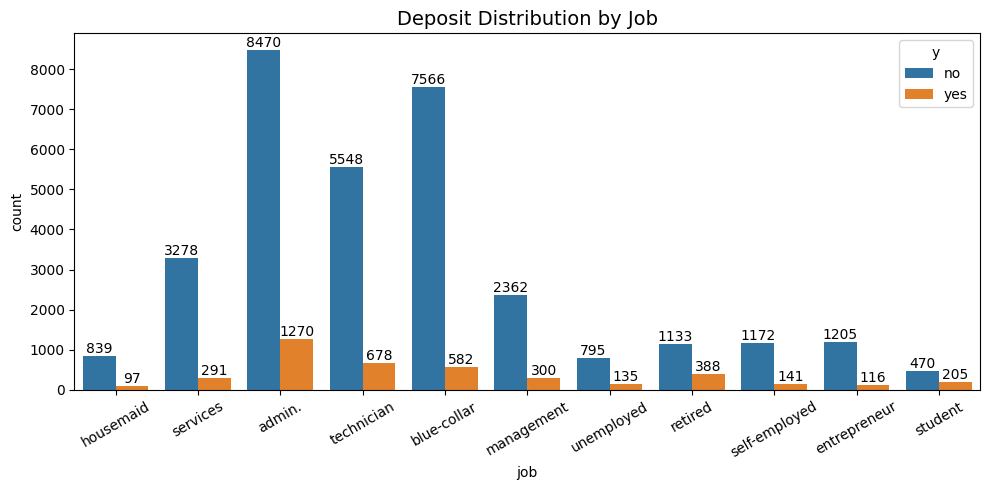

In [27]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='job',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Job',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [28]:
ratio = pd.crosstab(df["job"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
job,,
student,69.63,30.37
retired,74.49,25.51
unemployed,85.48,14.52
admin.,86.96,13.04
management,88.73,11.27
technician,89.11,10.89
self-employed,89.26,10.74
housemaid,89.64,10.36
entrepreneur,91.22,8.78


From the figure above, we can see that the variable Y is dependent by Job. We can see from the bar chart that:
1. The majority job is admin and we get most deposit from that occupation type
1. The highest deposit ratio comes from student
1. Interesting thing is that the deposit ratio for Retired and Student are 25% and 30%, even though they are the opposite type of job
    - Student trying out to put deposit in bank
    - Retired people for pension fund
1. Also, entrepreneur and management are most likely the people who have higher salary, but in this case decided not to put deposit. Most likely they have already put another deposit with another bank.

#### 2. Marital vs Y

In [29]:
a = pd.crosstab(df["marital"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Marital & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Marital & Y (deposit yes/no),7.855984e-20,Variables are dependent. Reject H0


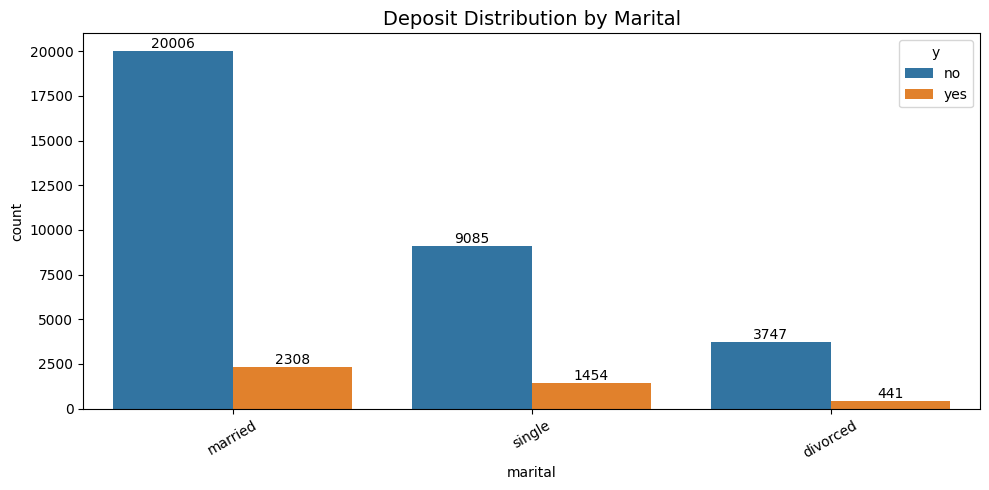

In [30]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='marital',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Marital',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [31]:
ratio = pd.crosstab(df["marital"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
marital,,
single,86.20,13.80
divorced,89.47,10.53
married,89.66,10.34


From the figure above, we can see that the variable Y is dependent by Marital. We can see from the bar chart that:
1. The chart is consistent with the count of total data count. The most deposit comes from married - single - divorced, alike with the category distribution of our data in previous analysis.
1. Most of our deposit customer comes from married people, since most of them are likely to be stable in terms of financial income.
1. But, the ratio of deposit for single people (14%) are higher than married people (11%).

#### 3. Education vs Y

In [32]:
a = pd.crosstab(df["education"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Education & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Education & Y (deposit yes/no),7.422098e-32,Variables are dependent. Reject H0


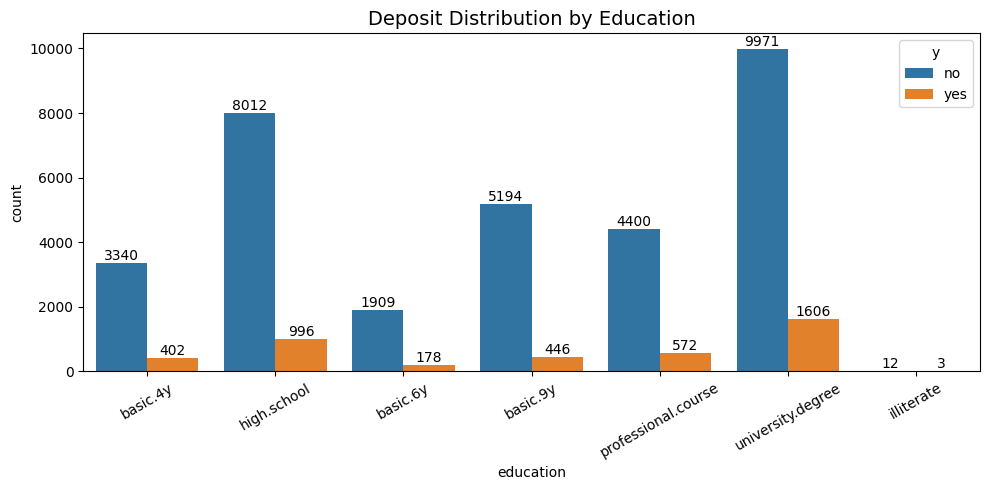

In [33]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='education',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Education',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [34]:
ratio = pd.crosstab(df["education"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
education,,
illiterate,80.00,20.00
university.degree,86.13,13.87
professional.course,88.50,11.50
high.school,88.94,11.06
basic.4y,89.26,10.74
basic.6y,91.47,8.53
basic.9y,92.09,7.91


From the figure above, we can see that the variable Y is dependent by Education. We can see from the bar chart that:
1. It is interesting to see that illiterate people also chose to open deposit, they sit in the highest deposit ratio rank. This means we shouldn't limit our customer based on their education demographics.
    - This may just be a coincidence in our dataset
    - It is still logical to chase after more people with university degree that sit on the 2nd rank of deposit ratio
1. Majority of people attended university and 13.7% of them decided to put a deposit. The lowest deposit ratio is on Basic 9y with 7% deposit ratio.

#### 4. Default vs Y

In [35]:
a = pd.crosstab(df["default"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Default & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Default & Y (deposit yes/no),1.0,Variables are independent. Accept H0


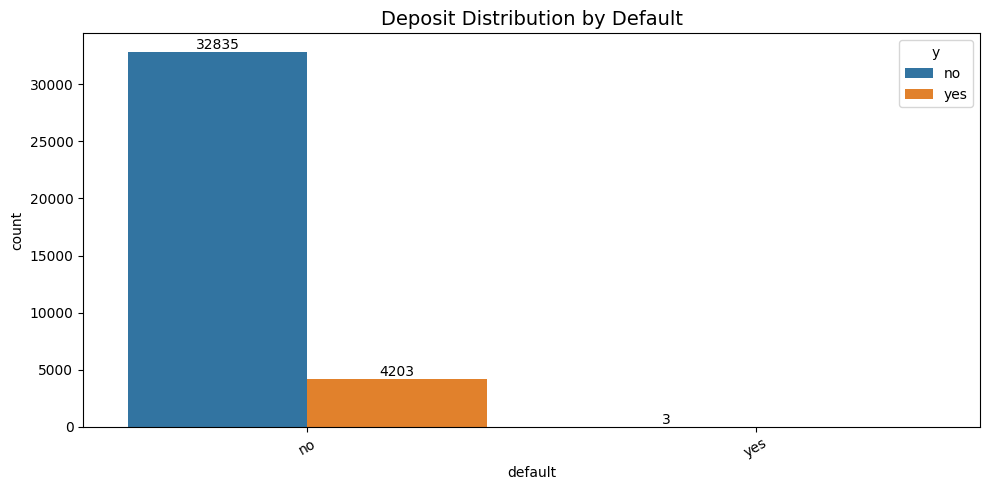

In [36]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='default',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Default',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [37]:
ratio = pd.crosstab(df["default"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
default,,
no,88.65,11.35
yes,100.00,0.00


From the figure above, we can see that the variable Y is independent by Default. We can see from the bar chart that:
1. It is logical that people who has credit won't open a deposit. This is proven by there's no people with credit who chose to open deposit.

#### 5. Housing vs Y

In [38]:
a = pd.crosstab(df["housing"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Housing & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Housing & Y (deposit yes/no),0.042276,Variables are dependent. Reject H0


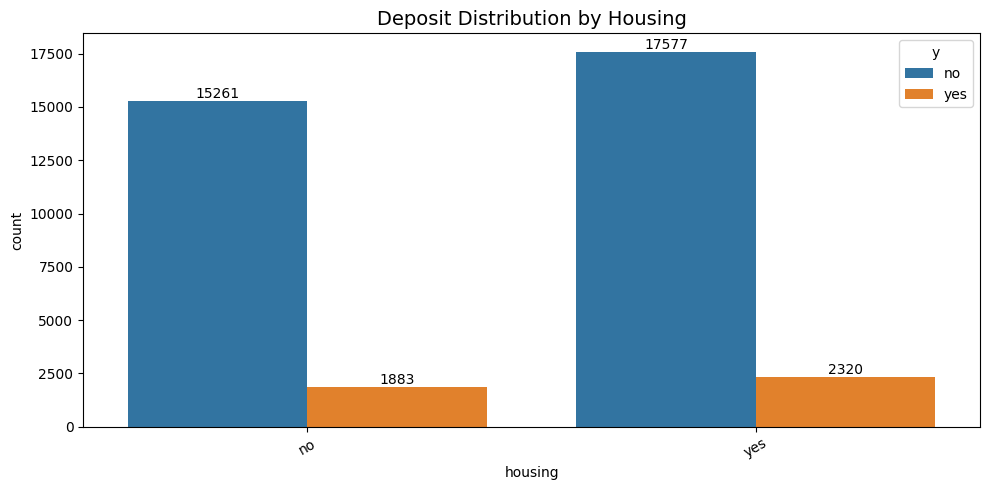

In [39]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='housing',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Housing',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [40]:
ratio = pd.crosstab(df["housing"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
housing,,
yes,88.34,11.66
no,89.02,10.98


From the figure above, we can see that the variable Y is dependent by Housing. We can see from the bar chart that:
1. The ratio of deposit between people who owns housing & no housing is quite similar
1. Most people who have housing are usually more stable, thus having more capability to put in a deposit

#### 6. Loan vs Y

In [41]:
a = pd.crosstab(df["loan"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Loan & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Loan & Y (deposit yes/no),0.033422,Variables are dependent. Reject H0


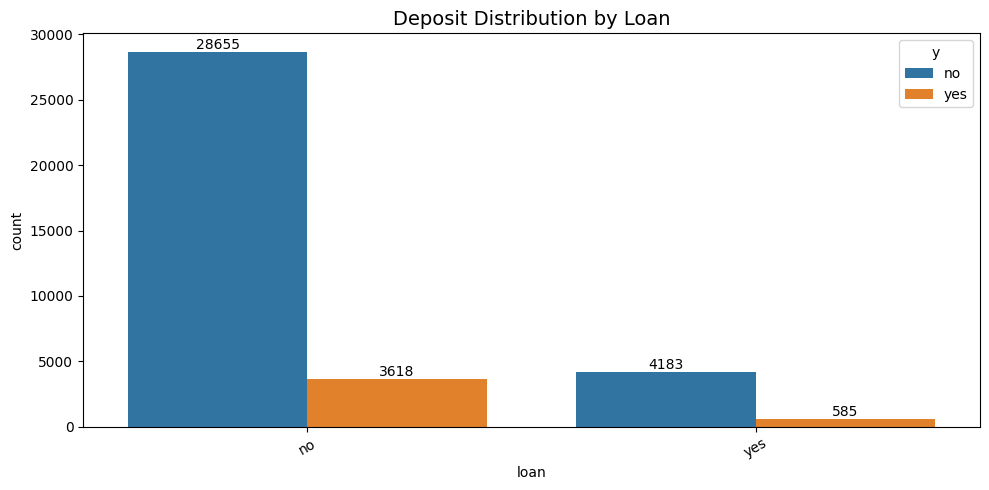

In [42]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='loan',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Loan',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [43]:
ratio = pd.crosstab(df["loan"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
loan,,
yes,87.73,12.27
no,88.79,11.21


From the figure above, we can see that the variable Y is dependent by Loan. We can see from the bar chart that:
1. The ratio of deposit from people who have loan and doesn't have loan is quite similar
1. Interestingly, people who have loan tends to put in deposit since they have higher deposit ratio

#### 7. Contact vs Y

In [44]:
a = pd.crosstab(df["contact"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Contact & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Contact & Y (deposit yes/no),1.610225e-165,Variables are dependent. Reject H0


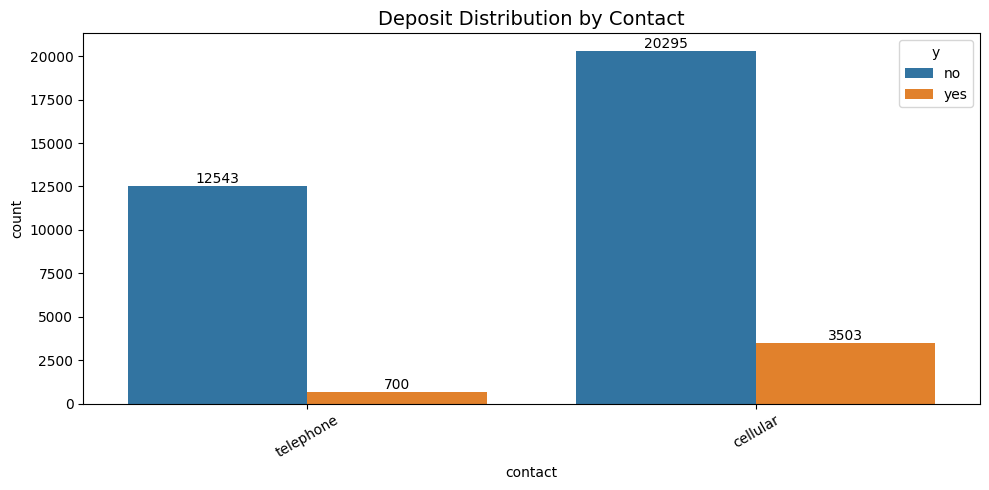

In [45]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='contact',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Contact',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [46]:
ratio = pd.crosstab(df["contact"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
contact,,
cellular,85.28,14.72
telephone,94.71,5.29


From the figure above, we can see that the variable Y is dependent by Contact. We can see from the bar chart that:
1. The dataset consisted of people who mostly used cellular, resulting in most deposit were made from cellular contact
1. However, there are still also people who used telephone but only resulted in 5% deposit out of the category. This is a small number compared to cellular which resulted in 15% deposit.

#### 8. Month vs Y

In [47]:
a = pd.crosstab(df["month"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Month & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Month & Y (deposit yes/no),0.0,Variables are dependent. Reject H0


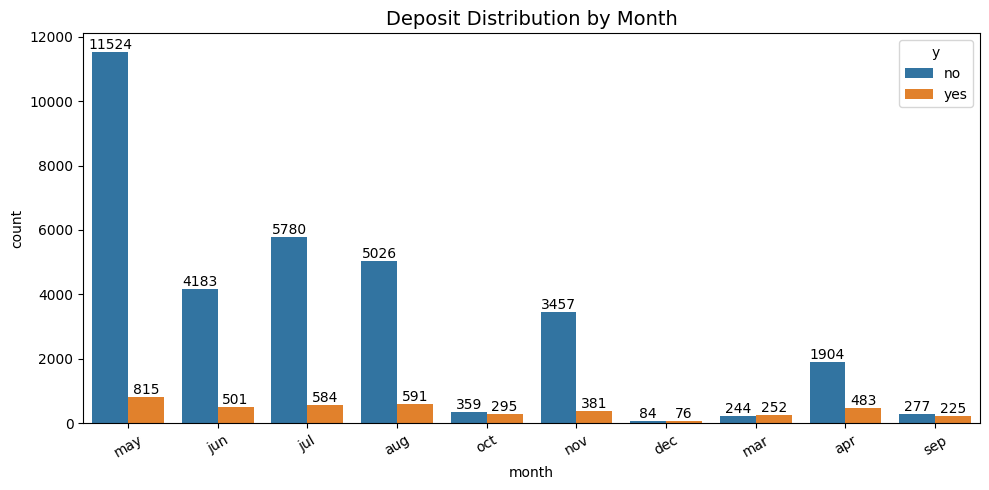

In [48]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='month',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Month',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [49]:
ratio = pd.crosstab(df["month"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
month,,
mar,49.19,50.81
dec,52.50,47.50
oct,54.89,45.11
sep,55.18,44.82
apr,79.77,20.23
jun,89.30,10.70
aug,89.48,10.52
nov,90.07,9.93
jul,90.82,9.18


From the figure above, we can see that the variable Y is dependent by Month. We can see from the bar chart that:
1. Most people were contacted in May and resulted in top deposit count compared to other month. But the deposit ratio is only 6%
1. The highest deposit ratio is rather on Mar, which has more people putting deposit than rejecting deposit.
1. Since the variables are dependent of each other, we need to consider contact month to determine the deposit result.

#### 9. Day_of_Week vs Y

In [50]:
a = pd.crosstab(df["day_of_week"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Day of Week & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Day of Week & Y (deposit yes/no),0.000189,Variables are dependent. Reject H0


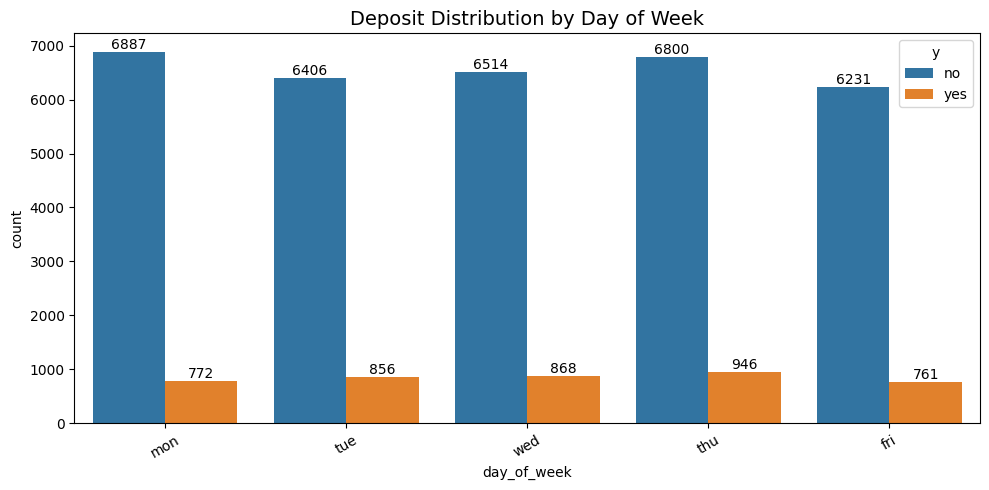

In [51]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='day_of_week',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Day of Week',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [52]:
ratio = pd.crosstab(df["day_of_week"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
day_of_week,,
thu,87.79,12.21
tue,88.21,11.79
wed,88.24,11.76
fri,89.12,10.88
mon,89.92,10.08


From the figure above, we can see that the variable Y is dependent by Day of Week. We can see from the bar chart that:
1. On each day, the data is similar with each other. But we can see that the highest deposit is resulted from calls made in Thursday, followed by Wednesday & Tuesday then Monday & Friday
1. But, based on the ratio, Friday produced higher deposit ratio than Monday.
1. Interestingly, there's similar deposit numbers between Monday and Friday
    - There's potential to reach out more deposit by calls in Friday compared to calls in Monday.

#### 10. Age Group vs Y

In [53]:
a = pd.crosstab(df["age_group"], df["y"])

stat_a, pval_a, dof_a, expected_a = chi2_contingency(a.fillna(0))
alpha = 0.05

data = ["Age Group & Y (deposit yes/no)"]
pval = [pval_a]
df_chi_sq = pd.DataFrame({"Data Testing": data, "P-Value": pval})
df_chi_sq["Hypothesis"] = np.where(
    df_chi_sq["P-Value"] < alpha,
    "Variables are dependent. Reject H0",
    "Variables are independent. Accept H0",
)
df_chi_sq

,Data Testing,P-Value,Hypothesis
0,Age Group & Y (deposit yes/no),5.165946e-162,Variables are dependent. Reject H0


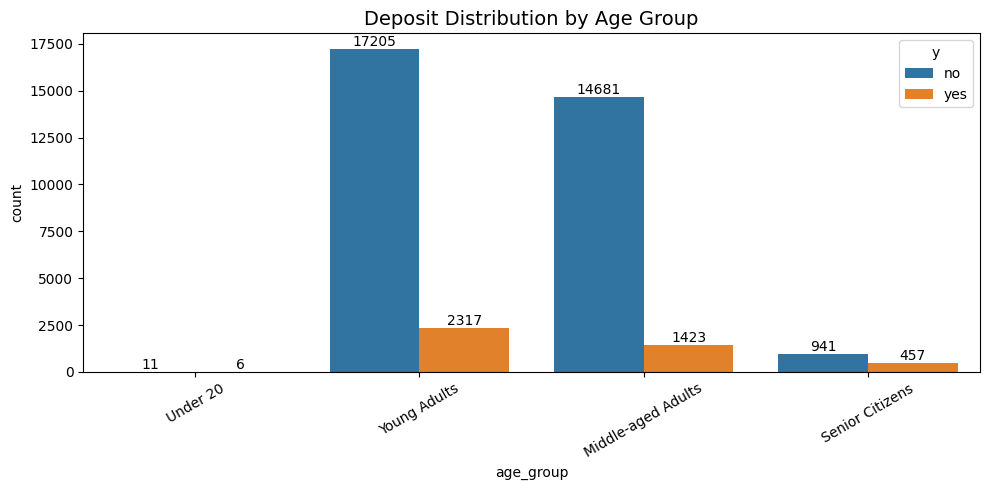

In [54]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='age_group',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Age Group',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [55]:
ratio = pd.crosstab(df["age_group"], df["y"], normalize='index')*100
ratio.sort_values(by='yes', ascending=False).round(decimals=2)

y,no,yes
age_group,,
Under 20,64.71,35.29
Senior Citizens,67.31,32.69
Young Adults,88.13,11.87
Middle-aged Adults,91.16,8.84


From the figure above, we can see that the variable Y is dependent by Age Group. We can see from the bar chart that:
1. There's higher deposit numbers from young adults compared to middle aged, senior, and under 20. We can safely assume that young adults are still productive hence able to save their money into deposit
1. The ratio of deposit is higher in senior citizen (33%) compared to middle aged (9%). This resulted in senior citizen that tends to be more stable in financial condition and have no more big spendings. While middle aged people still relatively have higher spending, but stagnant income.
1. People under 20 are most likely not productive and still a student. But they have the highest deposit ratio. The safe assumption is that they are learning how the bank deposit works

In [56]:
df[df['age_group']=='Under 20']['job']

24110    student
27792    student
30142    student
30349    student
35871    student
35872    student
37125    student
37539    student
37558    student
37626    student
38597    student
38832    student
39036    student
39039    student
39057    student
39903    student
41088    student
Name: job, dtype: object

This shows that all people under 20 is still a student and not a productive worker

Based on all the bar chart figures above on categorical data, we can conclude that the top customer profile that influence the decision to put deposit by using the highest deposit ratio. We use this so that we can result in higher deposit conversion if we got more people that matches the profile.
- Student
- Single
- University degree
    - The ratio is higher for illiterate people, but this might be a coincidence and it is safer to use the 2nd ratio rate which is uni degree.
- Have no credit (default)
- Have housing
- Have loan
- Call by cellular
- Call in March
- Call in Thursday
- Under 20

All the variables are dependent to the deposit decision except for default variable (have credit or not). But it is still advisable to consider people's credit condition since our data shows that no people with credit will open a deposit.

---

### Question 2: How does the economic condition influence customer's decision to put profit?

To better understand the economic condition data, we want to see their correlation between each other.

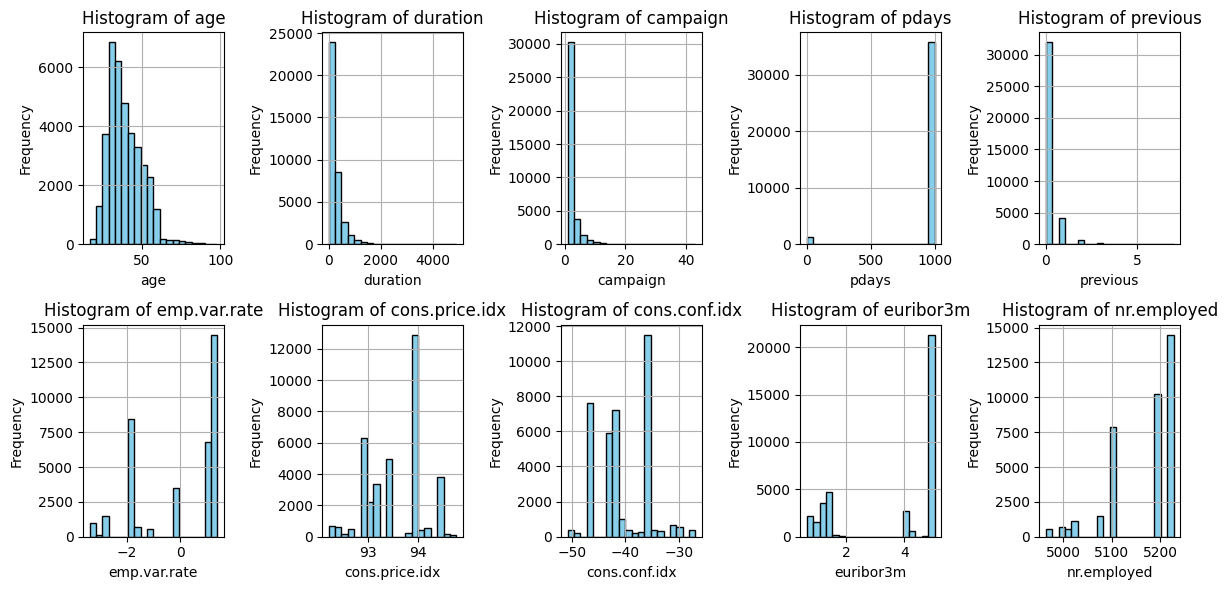

In [60]:
numerical_columns = ['age', 'duration', 'campaign','pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    axes[i].hist(df[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [61]:
skewness = {}
kurtosis_val = {}

for column in numerical_columns:
    skewness[column] = skew(df[column])
    kurtosis_val[column] = kurtosis(df[column])

for column in numerical_columns:
    print(f"{column}: Skewness={skewness[column]}, Kurtosis={kurtosis_val[column]}")

age: Skewness=0.830621020329774, Kurtosis=0.8835386116520194
duration: Skewness=3.3122788970918644, Kurtosis=20.99772718166843
campaign: Skewness=4.750646711038822, Kurtosis=35.70804063285213
pdays: Skewness=-4.935135609685378, Kurtosis=22.355989178124002
previous: Skewness=3.7922158173492058, Kurtosis=19.786867846358764
emp.var.rate: Skewness=-0.6947595840492625, Kurtosis=-1.100971331658125
cons.price.idx: Skewness=-0.1959890080369055, Kurtosis=-0.8468207413337345
cons.conf.idx: Skewness=0.3167604728966893, Kurtosis=-0.35795655772966306
euribor3m: Skewness=-0.68339100045489, Kurtosis=-1.4414826907487204
nr.employed: Skewness=-1.0239696542118308, Kurtosis=-0.0412678162654343


Based on these assessments: to determine the correlation the most suitable method was using spearman, considering data was not normal distribute.

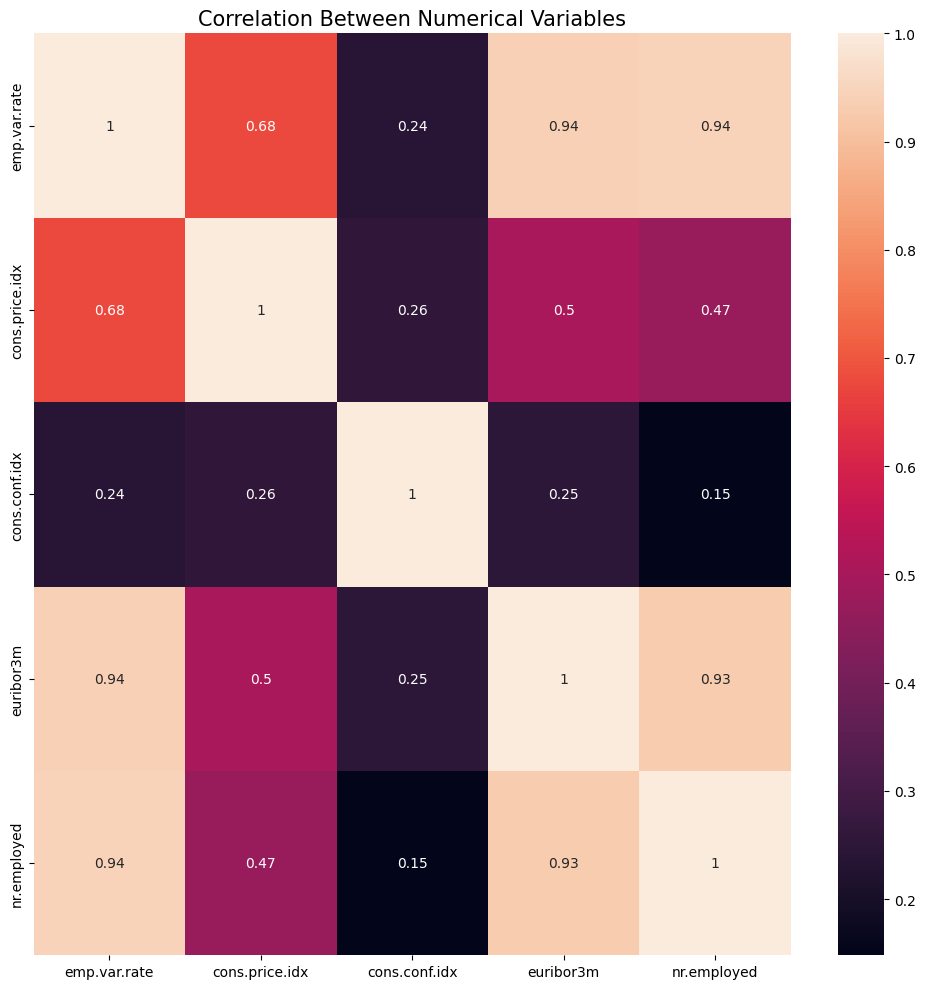

In [62]:
numerical_corr = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']].corr(method='spearman').round(3)
plt.figure(figsize=(10,10))
sns.heatmap(numerical_corr,annot=True)
plt.title('Correlation Between Numerical Variables',size=15)
plt.tight_layout()
plt.show()

# Positive correlation:
    1. emp.var.rate vs cons.price.idx (corr: 0.67)
    2. emp.var.rate vs euribor3m (corr: 0.94)
    3. emo.var.rate vs nr.employed (corr: 0.94)
    4. cons.price.idx vs euribor3m (corr: 0.49)
    5. cons.price.idx vs nr.employed (corr:0.47)

The strong correlations observed among variables such as emp.var.rate (Employment Variation Rate), cons.price.idx (Consumer Price Index), euribor3m (EURIBOR 3 Month Rate), and nr.employed (Number of Employees) are primarily due to their shared relevance to economic conditions. These indicators are interconnected, reflecting changes in employment rates, consumer prices, interest rates, and overall economic activity. For example, during economic expansions, employment rates typically rise alongside consumer spending, leading to increases in consumer prices and fluctuations in interest rates. As a result, these variables tend to move in tandem, capturing different aspects of the broader economic landscape and providing valuable insights into economic trends and policy effects.

---

Next, we're going to see how is the data distribution for each economic variables by y.

#### 1. Emp.var.rate

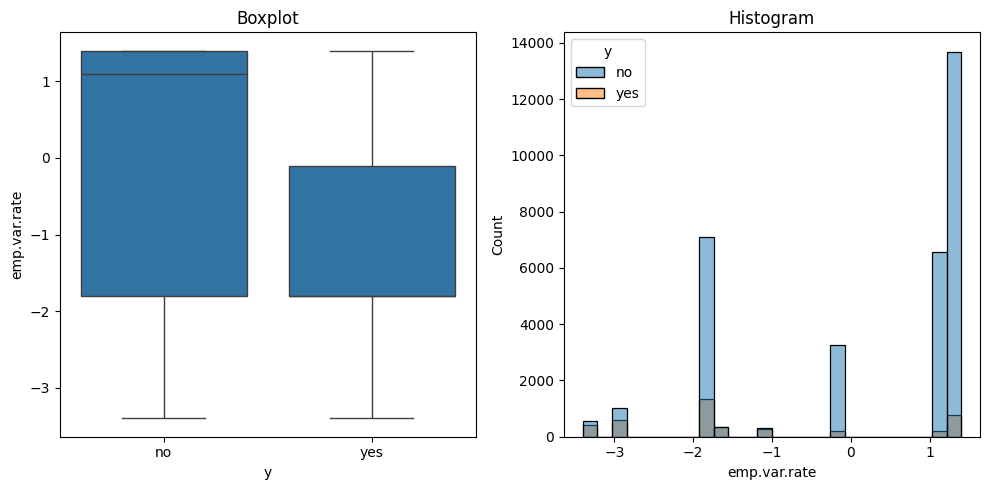

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='y', y='emp.var.rate', data=df, ax=axes[0])
axes[0].set_title('Boxplot')
sns.histplot(x='emp.var.rate', hue='y', data=df, ax=axes[1])
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

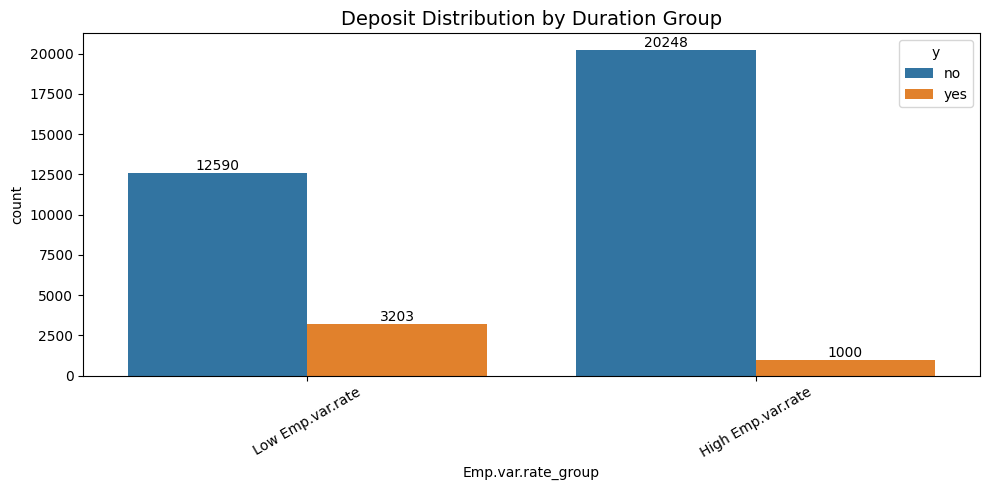

In [64]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='Emp.var.rate_group',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Duration Group',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- The data is not normally distributed for both yes and no variable.
- By grouping there's higher ratio of deposit decision on lower emp.var.rate
	- This can also be seen on the data distribution hue
- Lower emp.var.rate means that it indicates a more stable economic situation, leading to more confident in considering long-term deposit

#### 2. Cons price idx

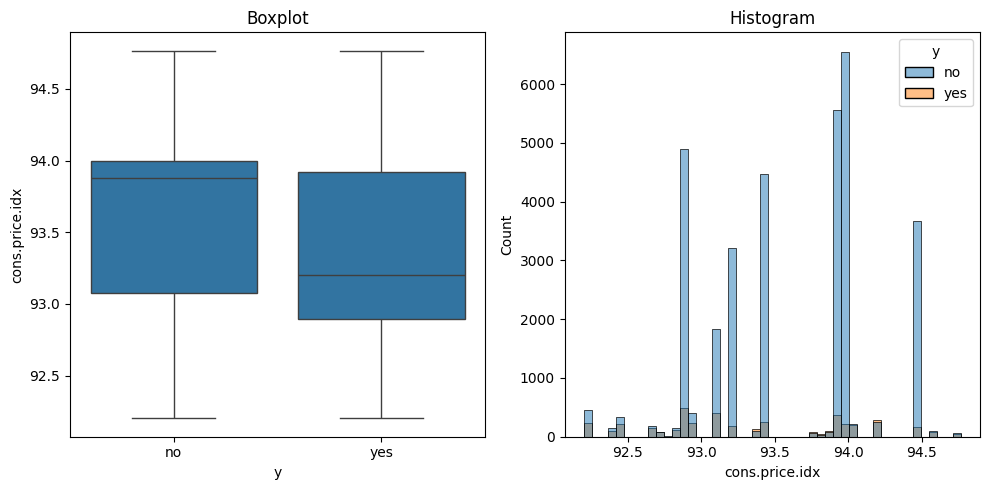

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='y', y='cons.price.idx', data=df, ax=axes[0])
axes[0].set_title('Boxplot')
sns.histplot(x='cons.price.idx', hue='y', data=df, ax=axes[1])
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

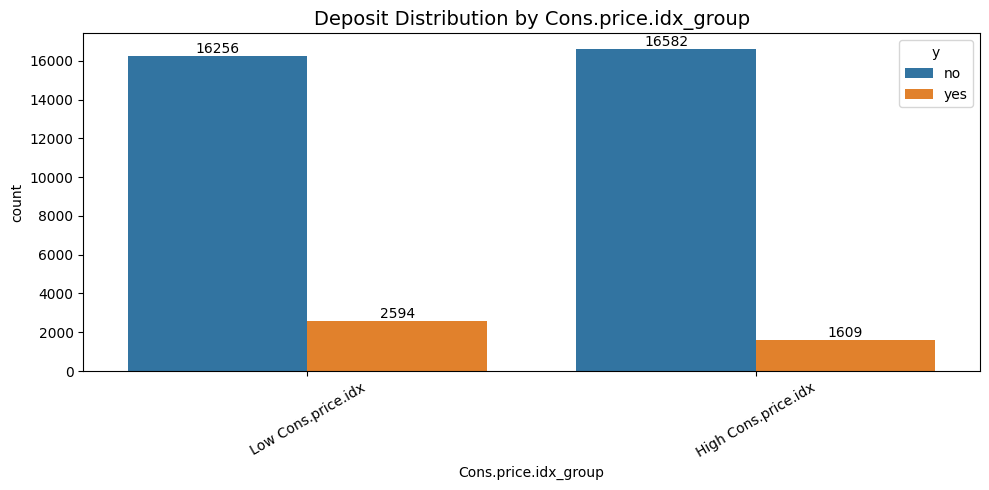

In [66]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='Cons.price.idx_group',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Cons.price.idx_group',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- The data is not normally distributed for both yes and no variable.
- By grouping there's higher ratio of deposit decision on lower cons.price.idx
	- This can also be seen on the data distribution hue
- Lower cons.price.idx means that it indicates a lower CPI indicates a lower or stable inflation. This allows a higher consumer purchasing power and allowing them to purchase more things than before

#### 3. Cons.conf.idx

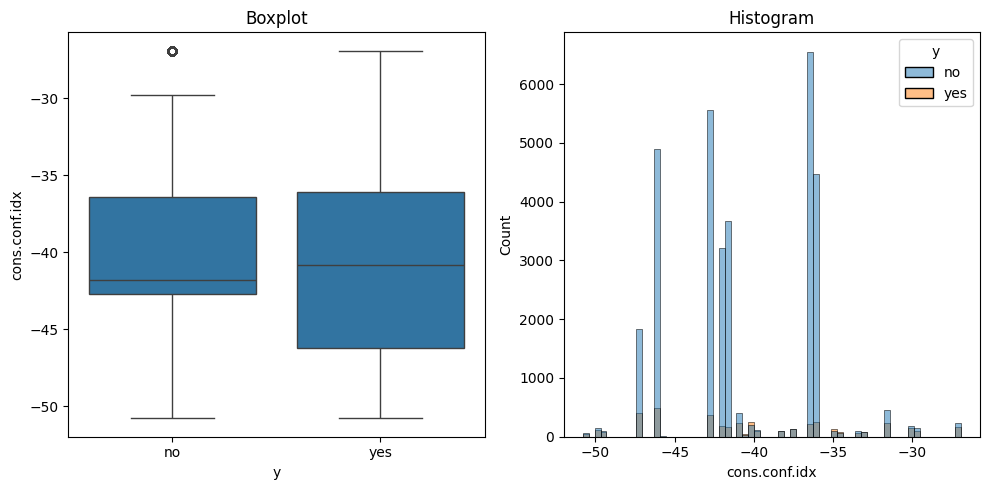

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='y', y='cons.conf.idx', data=df, ax=axes[0])
axes[0].set_title('Boxplot')
sns.histplot(x='cons.conf.idx', hue='y', data=df, ax=axes[1])
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

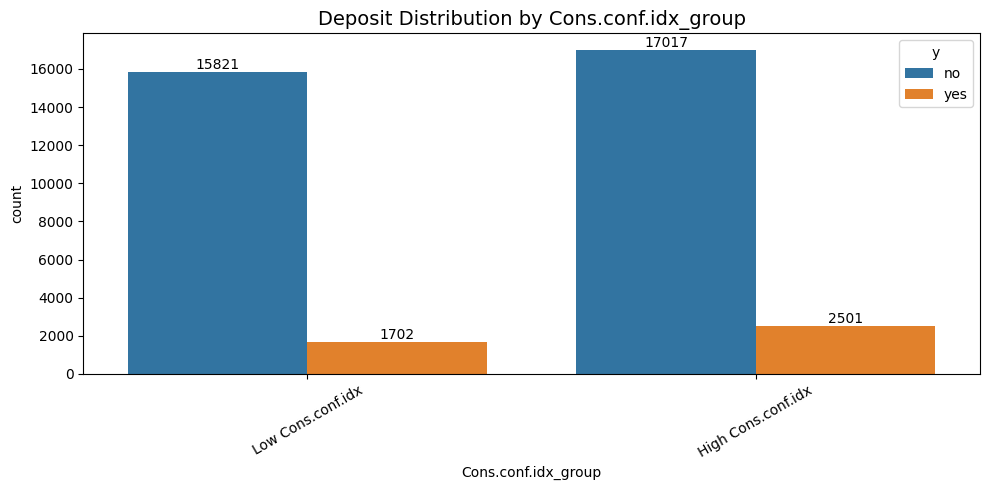

In [68]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='Cons.conf.idx_group',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Cons.conf.idx_group',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- The data is not normally distributed for both yes and no variable. It's observed that no variable has several outliers.
- By grouping there's higher ratio of deposit decision on higher cons.conf.idx
	- This can also be seen on the data distribution hue
- Higher cons.conf.idx means that it indicates more people who felt financially secure and lead to increase spending & investment behavior

#### 4. Euribor3m

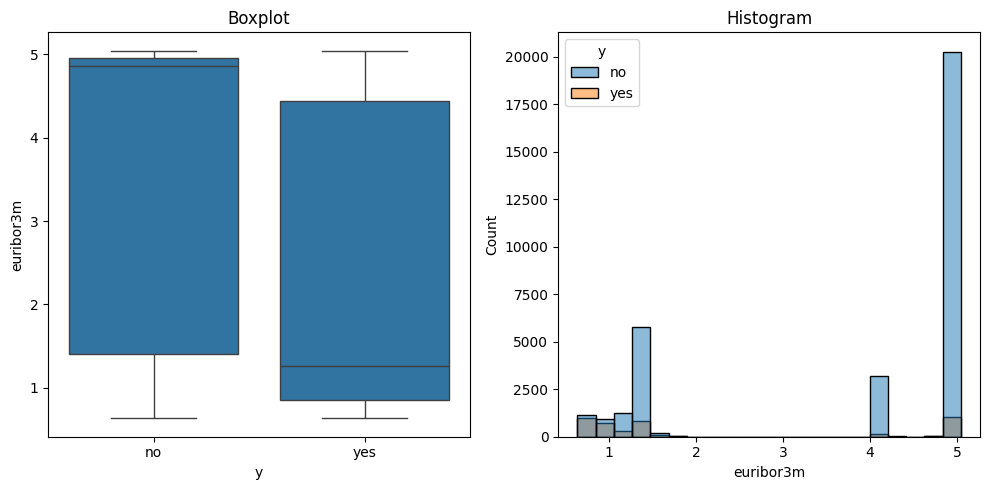

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='y', y='euribor3m', data=df, ax=axes[0])
axes[0].set_title('Boxplot')
sns.histplot(x='euribor3m', hue='y', data=df, ax=axes[1])
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

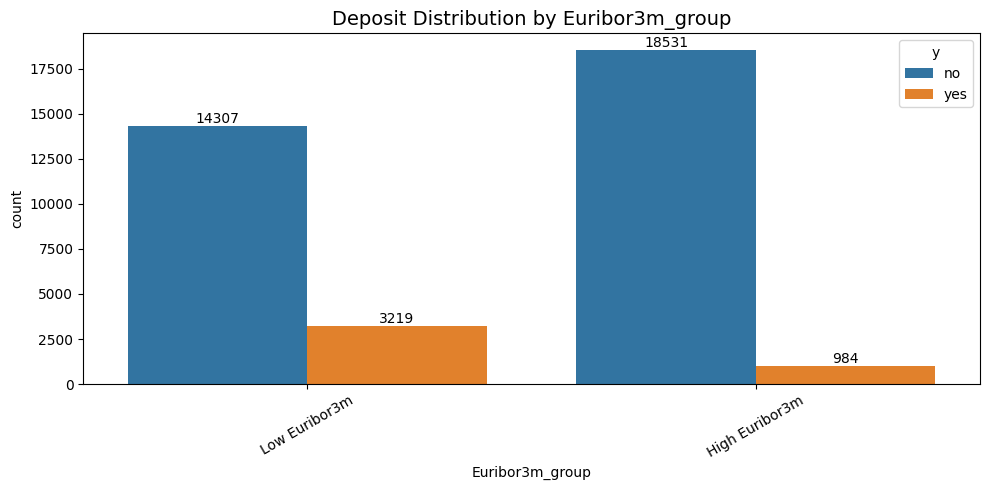

In [70]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='Euribor3m_group',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Euribor3m_group',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- The data is not normally distributed for both yes and no variable.
- By grouping there's higher ratio of deposit decision on lower Euribor3m
	- This can also be seen on the data distribution hue
- Lower Eurobor3m means that it indicates higher return and it's possible for banks to offer higher interest deposit rate. Higher return attracts more customers.

#### Nr.employed

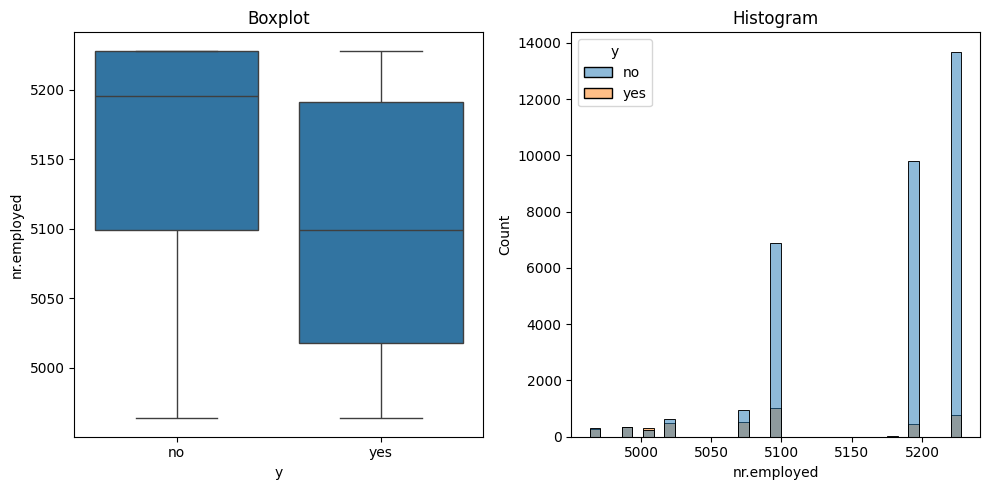

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='y', y='nr.employed', data=df, ax=axes[0])
axes[0].set_title('Boxplot')
sns.histplot(x='nr.employed', hue='y', data=df, ax=axes[1])
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

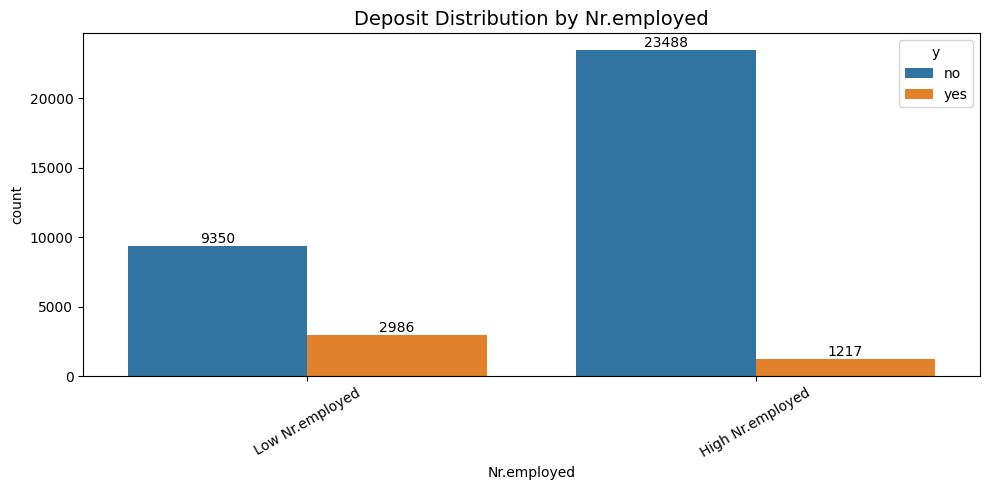

In [72]:
plt.figure(figsize=(10,5))

ax=sns.countplot(data=df, x='Nr.employed',hue='y')
for i in ax.containers:
    ax.bar_label(i)

plt.title('Deposit Distribution by Nr.employed',size=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- The data is not normally distributed for both yes and no variable with higher no data on high nr.employed.
- By grouping there's higher ratio of deposit decision on lower nr.employed
	- This can also be seen on the data distribution hue
- Lower nr.employed means that there's a decrease in number of employed individuals that may be resulted from layoff. Thus people would prioritize financial stability and deposit wouldn't be attractive to them.

---

In [73]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import BinaryEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

> ## Machine Learning: Data Preprocessing

Previously we had completed data cleaning for EDA purposes. For Machine Learning, we would like to take a second look to our dataset and transform them to all numerical variables. The Machine Learning used is **classification**, thus we should also adjust our target column (y) into 1 (yes) and 0 (no).

In [23]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'age_group',
       'Emp.var.rate_group', 'Cons.price.idx_group', 'Cons.conf.idx_group',
       'Euribor3m_group', 'Nr.employed'],
      dtype='object')

In [24]:
cfDesc = []
for i in df.columns:
    cfDesc.append(
        [
            i,
            df[i].dtypes,
            df[i].isna().sum(),
            round(df[i].isna().sum() / len(df) * 10, 2),
            df[i].nunique(),
            df[i].drop_duplicates().values
        ]
    )

pd.set_option("display.max_colwidth", 0)
pd.DataFrame(data=cfDesc, columns=["features", "DataType", "Null","Nullpercentage","Unique","Data"])

,features,DataType,Null,Nullpercentage,Unique,Data
0,age,int64,0,0.0,77,"[56, 57, 37, 40, 45, 59, 24, 25, 29, 35, 50, 39, 30, 55, 41, 54, 34, 52, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 49, 31, 43, 58, 36, 46, 28, 27, 26, 22, 23, 20, 21, 19, 18, 70, 61, 66, 76, 67, 73, 88, 95, 68, 75, 63, 80, 62, 65, 72, 64, 71, 69, 78, 85, 79, 77, 83, 81, 74, 82, 17, 87, 91, 98, 94, 86, 84, 89]"
1,job,object,0,0.0,11,"[housemaid, services, admin., technician, blue-collar, management, unemployed, retired, self-employed, entrepreneur, student]"
2,marital,object,0,0.0,3,"[married, single, divorced]"
3,education,object,0,0.0,7,"[basic.4y, high.school, basic.6y, basic.9y, professional.course, university.degree, illiterate]"
4,default,object,0,0.0,2,"[no, yes]"
5,housing,object,0,0.0,2,"[no, yes]"
6,loan,object,0,0.0,2,"[no, yes]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, sep]"
9,day_of_week,object,0,0.0,5,"[mon, tue, wed, thu, fri]"


### Define Target Column
Adjust target column format into 0 (no) and 1 (yes)

In [25]:
df['y'] = np.where(df['y']=='no', 0, 1)
df[['y']].value_counts()

y
0    32838
1    4203 
Name: count, dtype: int64

In [26]:
df['y'].unique()

array([0, 1])

### Feature Selection

Our model is aimed to predict the potential customer data. By having previous campaign data, it is redundant to have a model since we want to predict the deposit outcome based on the customer profile & economic profile rather than influence based on previous campaign. It is also unclear if the previous campaign is the same type of campaign or if it's relevant to the current deposit campaign.

Thus, we're going to remove all columns regarding previous campaign data which are 'duration', 'campaign', 'pdays', 'previous', 'poutcome'

Other than that, we're going to drop all grouping data since its purpose is to explore the data on data analysis above.

In [27]:
df.drop(columns=['duration', 'campaign', 'pdays', 'previous', 'poutcome'], inplace=True)
df.drop(columns=['age_group', 'Emp.var.rate_group', 'Cons.price.idx_group',
       'Cons.conf.idx_group', 'Euribor3m_group', 'Nr.employed'], inplace=True)

In [28]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,no,no,no,telephone,may,mon,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1.1,93.994,-36.4,4.857,5191.0,0


### Feature Engineering

With our cleaned data, we are ready to preprocess them before using them in the model. We will use multiple methods to transform our categorical data into numerical.
1. Label/Ordinal Encoder
    - Used for data that has order and it's important to keep the sequence as it is.
    - We use this to transform column: education
1. One Hot Encoder
    - This categorical data encoding can be used when the features do not have any order. The features will be mapped into multiple columns, subject to its unique variable numbers. We will also use drop first to reduce the complexity in our model.
    - We use this to transform column: marital, default, housing, loan, contact, day_of_week

Other than the encoder, we will also apply Robust Scaler for economic variable ('emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'). Robust Scaler is used due to both data not showing a normal distribution. We will not apply this for Age & Net Sales since we will drop them and use the categorized version instead.

In [80]:
ordinal_map = [
    {
        "col": "education",
        "mapping": {
            "illiterate": 0,
            "basic.4y": 1,
            "basic.6y": 2,
            "basic.9y": 3,
            "high.school": 4,
            "professional.course":5,
            "university.degree": 6,
        },
    }
]

transformer = ColumnTransformer(
    [
        ("ordinal", ce.OrdinalEncoder(mapping=ordinal_map), ["education"]),
        ("onehot", OneHotEncoder(drop="first"),["job", "month","marital", "default", "housing", "loan", "contact", "day_of_week"],),
        ("scaler", RobustScaler(), ['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']),
    ],
    remainder="passthrough",
)

### Data Splitting

In [93]:
x = df.drop(columns=["y"])
y = df["y"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, test_size=0.2, random_state=2024
)

Using stratify to ensure our data splitting is keeping the same proportion for Claim/No Claim data.

### Check Data Imbalance

In [82]:
y.value_counts()/len(y)*100

y
0    88.653114
1    11.346886
Name: count, dtype: float64

Turns out, out data is moderately imbalanced (11% minority class). We're going to use 2 types of benchmark modeling, which are without imbalance handling and with imbalanced handling.

### Variable after Transform

In [94]:
x_train_prep = transformer.fit_transform(x_train)
column_prep = transformer.get_feature_names_out()

x_train_prep = pd.DataFrame(data=x_train_prep, columns=column_prep)
display(x_train_prep, x_train_prep.columns)

,ordinal__education,onehot__job_blue-collar,onehot__job_entrepreneur,onehot__job_housemaid,onehot__job_management,onehot__job_retired,onehot__job_self-employed,onehot__job_services,onehot__job_student,onehot__job_technician,...,onehot__day_of_week_mon,onehot__day_of_week_thu,onehot__day_of_week_tue,onehot__day_of_week_wed,scaler__cons.price.idx,scaler__cons.conf.idx,scaler__euribor3m,remainder__age,remainder__emp.var.rate,remainder__nr.employed
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,-0.265506,-0.031746,-0.215329,43.0,-0.1,5195.8
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.110990,0.000000,0.028674,56.0,1.4,5228.1
2,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,0.904762,0.029501,46.0,1.4,5228.1
3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.515778,-0.142857,0.028950,40.0,1.4,5228.1
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,-0.599565,-0.698413,-0.983182,38.0,-1.8,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29627,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.598477,0.857143,0.000000,25.0,1.1,5191.0
29628,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.000000,0.904762,0.028950,30.0,1.4,5228.1
29629,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.865071,1.857143,-1.141715,55.0,-3.4,5017.5
29630,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.598477,0.857143,0.000000,30.0,1.1,5191.0


Index(['ordinal__education', 'onehot__job_blue-collar',
       'onehot__job_entrepreneur', 'onehot__job_housemaid',
       'onehot__job_management', 'onehot__job_retired',
       'onehot__job_self-employed', 'onehot__job_services',
       'onehot__job_student', 'onehot__job_technician',
       'onehot__job_unemployed', 'onehot__month_aug', 'onehot__month_dec',
       'onehot__month_jul', 'onehot__month_jun', 'onehot__month_mar',
       'onehot__month_may', 'onehot__month_nov', 'onehot__month_oct',
       'onehot__month_sep', 'onehot__marital_married',
       'onehot__marital_single', 'onehot__default_yes', 'onehot__housing_yes',
       'onehot__loan_yes', 'onehot__contact_telephone',
       'onehot__day_of_week_mon', 'onehot__day_of_week_thu',
       'onehot__day_of_week_tue', 'onehot__day_of_week_wed',
       'scaler__cons.price.idx', 'scaler__cons.conf.idx', 'scaler__euribor3m',
       'remainder__age', 'remainder__emp.var.rate', 'remainder__nr.employed'],
      dtype='object')

### Check Multicollinearity

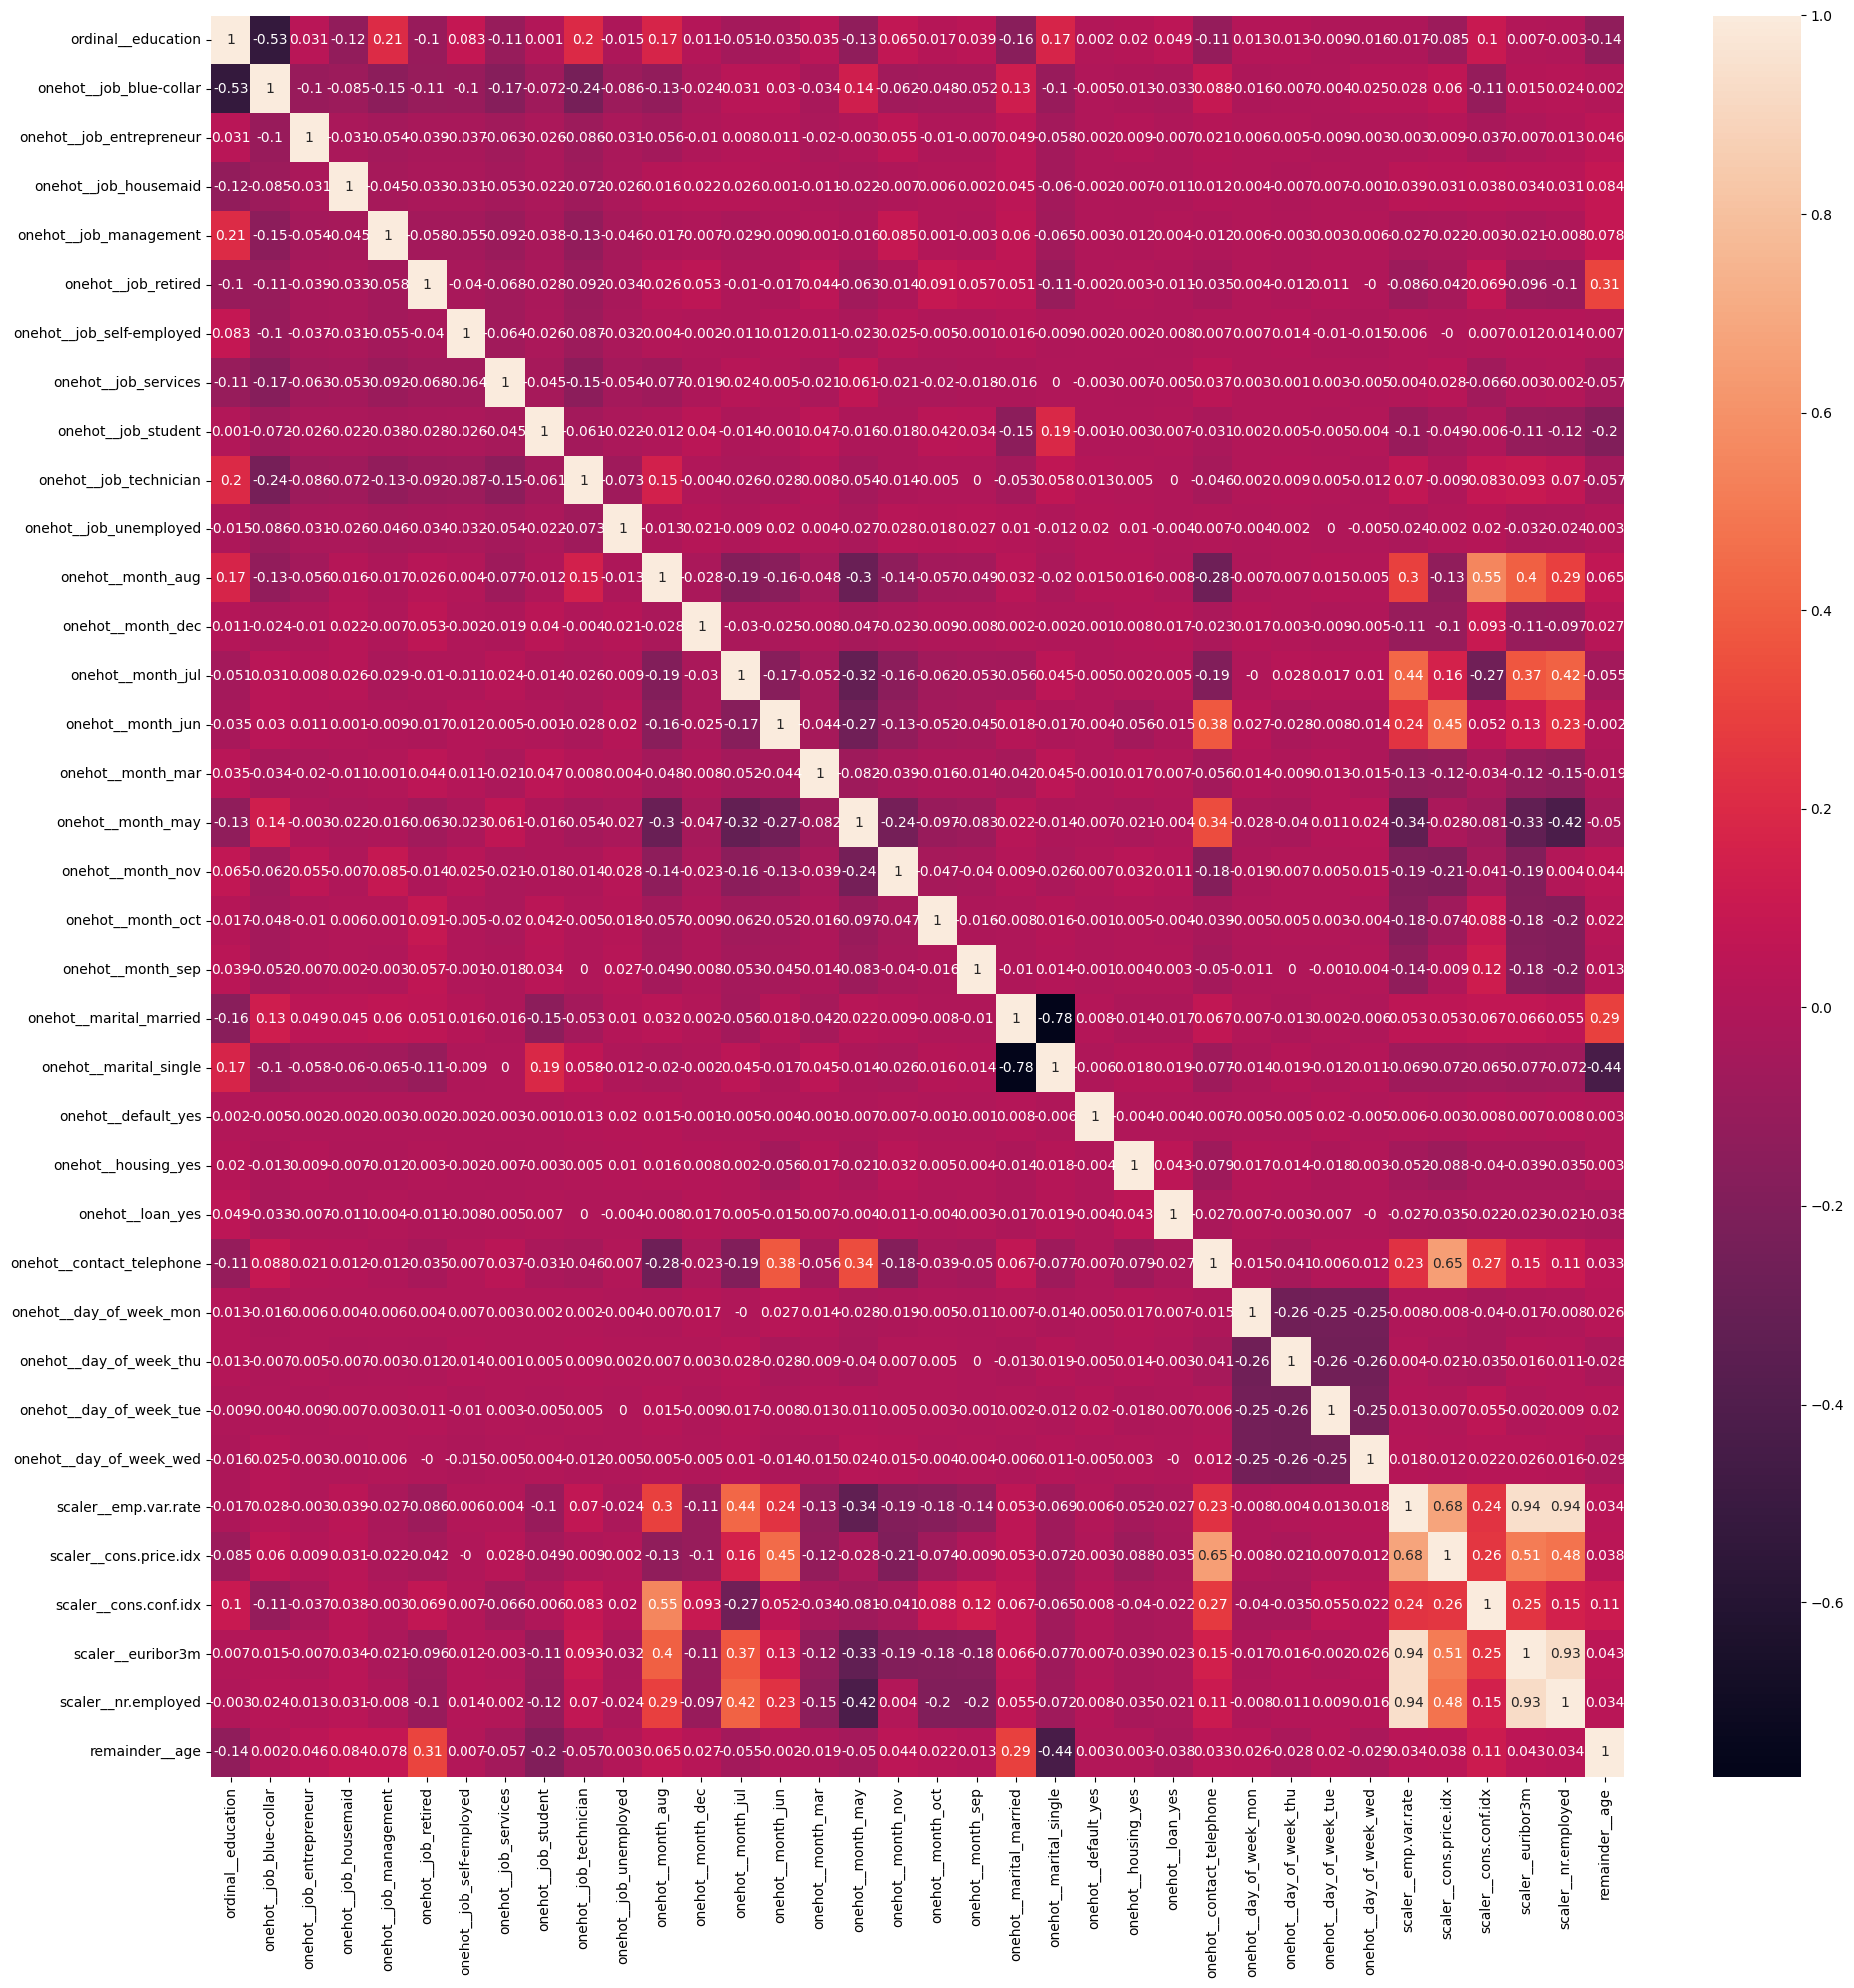

In [84]:
numerical_corr = x_train_prep.corr(method='spearman').round(3)
plt.figure(figsize=(20,20))
sns.heatmap(numerical_corr,annot=True)
plt.tight_layout()
plt.show()

We can see that our variable emp.var.rate and nr.employed has high correlation above 90% with each other & euribor3m. We're going to use euribor3m since it is essential in terms of deposit rate in Europe. The variable emp.var.rate & nr.employed will be dropped.

### Drop Multicollinearity Column

In [146]:
ordinal_map = [
    {
        "col": "education",
        "mapping": {
            "illiterate": 0,
            "basic.4y": 1,
            "basic.6y": 2,
            "basic.9y": 3,
            "high.school": 4,
            "professional.course":5,
            "university.degree": 6,
        },
    }
]

transformer = ColumnTransformer(
    [
        ("ordinal", ce.OrdinalEncoder(mapping=ordinal_map, handle_unknown='ignore'), ["education"]),
        ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'),["job", "month","marital", "default", "housing", "loan", "contact", "day_of_week"],),
        ("scaler", RobustScaler(), ['cons.price.idx','cons.conf.idx', 'euribor3m']),
    ],
    remainder="passthrough",
)

In [96]:
x = df.drop(columns=["y","emp.var.rate","nr.employed"])
y = df["y"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, test_size=0.2, random_state=2024
)

In [97]:
x_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
26726,43,technician,married,professional.course,no,yes,yes,cellular,nov,thu,93.200,-42.0,4.076
10727,56,retired,married,basic.4y,no,no,no,telephone,jun,tue,94.465,-41.8,4.961
22019,46,self-employed,married,university.degree,no,no,no,cellular,aug,wed,93.444,-36.1,4.964
13274,40,unemployed,married,university.degree,no,yes,no,cellular,jul,wed,93.918,-42.7,4.962
33127,38,technician,married,high.school,no,yes,no,cellular,may,tue,92.893,-46.2,1.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6836,25,self-employed,single,university.degree,no,yes,no,telephone,may,wed,93.994,-36.4,4.857
23596,30,technician,married,university.degree,no,no,no,cellular,aug,thu,93.444,-36.1,4.962
38926,55,management,married,university.degree,no,yes,no,cellular,nov,wed,92.649,-30.1,0.716
5626,30,services,married,high.school,no,yes,no,telephone,may,mon,93.994,-36.4,4.857


In [103]:
x_train_prep = transformer.fit_transform(x_train).toarray()
column_prep = transformer.get_feature_names_out()

x_train_prep = pd.DataFrame(data=x_train_prep, columns=column_prep)
display(x_train_prep, x_train_prep.columns)

,ordinal__education,onehot__job_blue-collar,onehot__job_entrepreneur,onehot__job_housemaid,onehot__job_management,onehot__job_retired,onehot__job_self-employed,onehot__job_services,onehot__job_student,onehot__job_technician,...,onehot__loan_yes,onehot__contact_telephone,onehot__day_of_week_mon,onehot__day_of_week_thu,onehot__day_of_week_tue,onehot__day_of_week_wed,scaler__cons.price.idx,scaler__cons.conf.idx,scaler__euribor3m,remainder__age
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,-0.265506,-0.031746,-0.215329,43.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.110990,0.000000,0.028674,56.0
2,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.904762,0.029501,46.0
3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.515778,-0.142857,0.028950,40.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.599565,-0.698413,-0.983182,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29627,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.598477,0.857143,0.000000,25.0
29628,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.904762,0.028950,30.0
29629,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.865071,1.857143,-1.141715,55.0
29630,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.598477,0.857143,0.000000,30.0


Index(['ordinal__education', 'onehot__job_blue-collar',
       'onehot__job_entrepreneur', 'onehot__job_housemaid',
       'onehot__job_management', 'onehot__job_retired',
       'onehot__job_self-employed', 'onehot__job_services',
       'onehot__job_student', 'onehot__job_technician',
       'onehot__job_unemployed', 'onehot__month_aug', 'onehot__month_dec',
       'onehot__month_jul', 'onehot__month_jun', 'onehot__month_mar',
       'onehot__month_may', 'onehot__month_nov', 'onehot__month_oct',
       'onehot__month_sep', 'onehot__marital_married',
       'onehot__marital_single', 'onehot__default_yes', 'onehot__housing_yes',
       'onehot__loan_yes', 'onehot__contact_telephone',
       'onehot__day_of_week_mon', 'onehot__day_of_week_thu',
       'onehot__day_of_week_tue', 'onehot__day_of_week_wed',
       'scaler__cons.price.idx', 'scaler__cons.conf.idx', 'scaler__euribor3m',
       'remainder__age'],
      dtype='object')

---

> ## Model Benchmarking - Without Imbalance Handling

In [104]:
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(random_state=2024)
ada = AdaBoostClassifier(random_state=2024)
gb = GradientBoostingClassifier(random_state=2024)
xgb = XGBClassifier()

model = [logreg,knn,tree,rf,ada,gb,xgb]
score = []
score_mean = []
score_std = []
score_data = []
result_model = []

for i in model:
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('transformer',transformer),
        ('model',i)])
    model_cv = cross_val_score(estimator, x_train, y_train, cv=skfold, scoring='f1')
    
    result_model.append(str(i).split('(')[0])
    score_mean.append(model_cv.mean())
    score_std.append(model_cv.std())
    score_data.append(model_cv.round(2))
    
benchmark_1 = pd.DataFrame({
    'Model' : result_model,
    'Score F1' : score_mean,
    'Score Std' : score_std,
    'Score Data' : score_data
    }).sort_values(by='Score F1',ascending=False)
benchmark_1

,Model,Score F1,Score Std,Score Data
6,XGBClassifier,0.350424,0.016039,"[0.33, 0.36, 0.37, 0.34, 0.35]"
3,RandomForestClassifier,0.343322,0.022503,"[0.31, 0.37, 0.36, 0.33, 0.34]"
5,GradientBoostingClassifier,0.328560,0.013420,"[0.31, 0.35, 0.34, 0.31, 0.33]"
2,DecisionTreeClassifier,0.310677,0.012451,"[0.29, 0.32, 0.32, 0.31, 0.3]"
0,LogisticRegression,0.287743,0.015729,"[0.26, 0.29, 0.31, 0.29, 0.29]"
4,AdaBoostClassifier,0.286847,0.028896,"[0.28, 0.24, 0.31, 0.28, 0.32]"
1,KNeighborsClassifier,0.267952,0.017183,"[0.25, 0.26, 0.3, 0.26, 0.28]"


> ## Model Benchmarking - With Imbalance Handling

From the calculation above, we understand that we currently have 11% minority class. We would try several methods for resampling to adjust both classes to produce a better model for our dataset.
1. **Random Under Sampler**<br>
    RUS method deletes our majority class in random ways so that it matches the minority class proportion. This method has a big risk of losing information from our data, especially if our dataset is small. In this case, our insurace dataset is moderate size (38k rows), thus we can try to use this method.<br>
    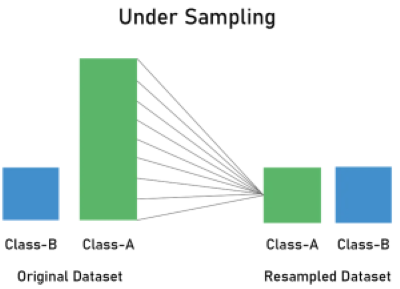
    
1. **Random Over Sampler**<br>
    ROS method adds copies on our minority class in random ways so that it matches the majority class proportion. This method is quite risky in overfitting. Since we are comparing our model, we can use this method too as a comparison.<br>
    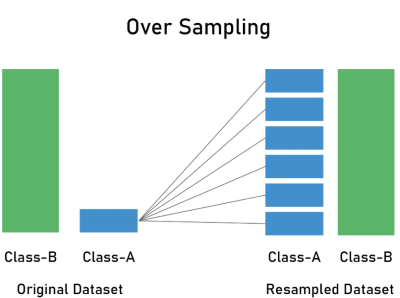
    
1. **Near Miss**<br>
    NearMiss method is used to balance the class distribution by selecting several majority class instances that is near minority class. We are using sampling_strategy = 'majority' to focus keeping majority class instance that is close to minority class.<br>
    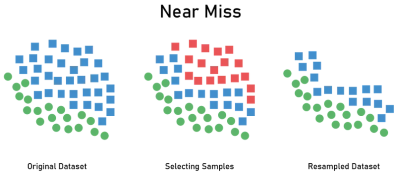

1. **SMOTE**<br>
    SMOTE or Synthetic Minority Over-sampling Technique is a method that generates synthetic samples for the minority class and oversampling them to balance the class distribution. This method tries to avoid overfitting that copies the data instead of creating synthetic sample.<br>
    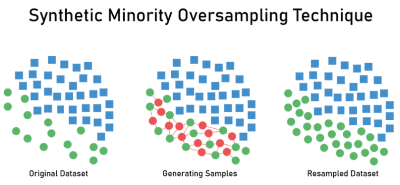

> Illustration Source: https://heartbeat.comet.ml/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

We are going to try out those 4 resampler methods to our model and find out which one performs the best.

In [105]:
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(random_state=2024)
ada = AdaBoostClassifier(random_state=2024)
gb = GradientBoostingClassifier(random_state=2024)
xgb = XGBClassifier()

categorical_indices = [3]
ros = RandomOverSampler(random_state=2024)
rus = RandomUnderSampler(random_state=2024)
smote = SMOTE(random_state=2024)
nearmiss = NearMiss(sampling_strategy='majority')

model = [logreg,knn,tree,rf,ada,gb,xgb]
resampler = [ros, smote, nearmiss, rus]
score_mean = []
score_std = []
score_data = []
result_model = []
result_resampler = []

for i in model:
    for j in resampler:
        skfold=StratifiedKFold(n_splits=5)
        estimator=Pipeline([
            ('preprocess',transformer),
            ('resampler', j),
            ('model',i)])
        model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
        
        result_model.append(str(i).split('(')[0])
        result_resampler.append(str(j).split('(')[0])
        score_mean.append(model_cv.mean())
        score_std.append(model_cv.std())
        score_data.append(model_cv.round(2))
    
benchmark_2 = pd.DataFrame({
    'Model' : result_model,
    'Resampler' : result_resampler,
    'Score F1' : score_mean,
    'Score Std' : score_std,
    'Score Data' : score_data
    }).sort_values(by='Score F1',ascending=False)
benchmark_2

,Model,Resampler,Score F1,Score Std,Score Data
21,GradientBoostingClassifier,SMOTE,0.468626,0.019467,"[0.47, 0.49, 0.49, 0.44, 0.46]"
20,GradientBoostingClassifier,RandomOverSampler,0.454279,0.009369,"[0.46, 0.46, 0.46, 0.44, 0.45]"
23,GradientBoostingClassifier,RandomUnderSampler,0.451989,0.008799,"[0.45, 0.44, 0.47, 0.44, 0.46]"
17,AdaBoostClassifier,SMOTE,0.450040,0.011471,"[0.44, 0.45, 0.46, 0.44, 0.47]"
16,AdaBoostClassifier,RandomOverSampler,0.439106,0.006573,"[0.43, 0.45, 0.44, 0.43, 0.45]"
19,AdaBoostClassifier,RandomUnderSampler,0.438216,0.010856,"[0.43, 0.44, 0.46, 0.44, 0.43]"
3,LogisticRegression,RandomUnderSampler,0.432994,0.008137,"[0.43, 0.43, 0.44, 0.42, 0.44]"
0,LogisticRegression,RandomOverSampler,0.429652,0.009753,"[0.44, 0.42, 0.43, 0.42, 0.43]"
24,XGBClassifier,RandomOverSampler,0.425615,0.014692,"[0.42, 0.45, 0.43, 0.41, 0.42]"
1,LogisticRegression,SMOTE,0.419721,0.010657,"[0.43, 0.42, 0.43, 0.4, 0.42]"


### Testing Dataset using Model Benchmark (with Imbalance Handling)

The model used for this first testing dataset is GradientBoosterClassifier with SMOTE

In [136]:
# Modelling
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=SMOTE(random_state=2024)
model=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

model.fit(x_train, y_train)

# Model prediction in Test Set
y_pred_bm2 = model.predict(x_test)
print('Classification Report \n',classification_report(y_test, y_pred_bm2))
print('Accuracy Score',accuracy_score(y_test, y_pred_bm2))
print('F1 Score',f1_score(y_test, y_pred_bm2))

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      6568
           1       0.45      0.49      0.47       841

    accuracy                           0.88      7409
   macro avg       0.69      0.71      0.70      7409
weighted avg       0.88      0.88      0.88      7409

Accuracy Score 0.8751518423538939
F1 Score 0.46869615163699024


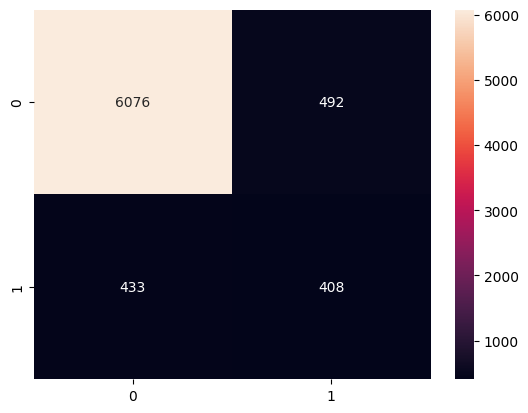

In [107]:
sns.heatmap(confusion_matrix(y_test, y_pred_bm2), annot=True, fmt='.4g');

Using F1 score, we aim to reduce both False Positive & False Negative. Using the current training dataset, we produced a model that has F1 score of 46.8% in testing dataset. This score is able to be improved by hyperparameter tuning for the top 3 score in our variation of model & imbalance handling method. We chose to use the model with imbalance handling due to the higher score they produced compared with no imbalance handling.

- False Positive: 492
- False Negative: 433
- True Positive: 408
- True Negative: 6076
- Accuracy: 87.5%
- F1 score: 46.8%

---

> ## Hyperparameter Tuning 1: GBC & SMOTE

We are going to try 2 times hyperparameter tuning to ensure the result is the best one. The hyperparameter we're going to use are:
- n_estimators
- learning_rate
- max_depth

We also include the hyperparameter from default setting so we have a better comparison. The default param is:
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3

### 1st Tuning

In [108]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=SMOTE(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
}

grid_search_gbc_smote = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_smote.fit(x_train, y_train)

best_param_gbc_smote = grid_search_gbc_smote.best_params_
best_score_gbc_smote = grid_search_gbc_smote.best_score_
result_gbc_smote = grid_search_gbc_smote.cv_results_

print("best parameter: ", best_param_gbc_smote)
print("best score mean: ", best_score_gbc_smote)

best parameter:  {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 200}
best score mean:  0.48705262774435354


### 2nd Tuning

In [109]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=SMOTE(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [200, 300, 400],
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__max_depth': [7, 9, 11],
}

grid_search_gbc_smote_2 = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_smote_2.fit(x_train, y_train)

best_param_gbc_smote_2 = grid_search_gbc_smote_2.best_params_
best_score_gbc_smote_2 = grid_search_gbc_smote_2.best_score_
result_gbc_smote_2 = grid_search_gbc_smote_2.cv_results_

print("best parameter: ", best_param_gbc_smote_2)
print("best score mean: ", best_score_gbc_smote_2)

best parameter:  {'model__learning_rate': 0.005, 'model__max_depth': 7, 'model__n_estimators': 400}
best score mean:  0.4874850539153063


> ## Hyperparameter Tuning 2: GBC & ROS

We are going to try 2 times hyperparameter tuning to ensure the result is the best one. The hyperparameter we're going to use are:
- n_estimators
- learning_rate
- max_depth

We also include the hyperparameter from default setting so we have a better comparison. The default param is:
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3

### 1st Tuning

In [110]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=RandomOverSampler(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
}

grid_search_gbc_ros = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_ros.fit(x_train, y_train)

best_param_gbc_ros = grid_search_gbc_ros.best_params_
best_score_gbc_ros = grid_search_gbc_ros.best_score_
result_gbc_ros = grid_search_gbc_ros.cv_results_

print("best parameter: ", best_param_gbc_ros)
print("best score mean: ", best_score_gbc_ros)

best parameter:  {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 200}
best score mean:  0.46783789345213195


### 2nd Tuning

In [111]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=RandomOverSampler(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [20, 40, 50],
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__max_depth': [5, 9, 11],
}

grid_search_gbc_ros_2 = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_ros_2.fit(x_train, y_train)

best_param_gbc_ros_2 = grid_search_gbc_ros_2.best_params_
best_score_gbc_ros_2 = grid_search_gbc_ros_2.best_score_
result_gbc_ros_2 = grid_search_gbc_ros_2.cv_results_

print("best parameter: ", best_param_gbc_ros_2)
print("best score mean: ", best_score_gbc_ros_2)

best parameter:  {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 50}
best score mean:  0.46600863484783933


> ## Hyperparameter Tuning 3: GBC & ROS

We are going to try 2 times hyperparameter tuning to ensure the result is the best one. The hyperparameter we're going to use are:
- n_estimators
- learning_rate
- max_depth

We also include the hyperparameter from default setting so we have a better comparison. The default param is:
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3

### 1st Tuning

In [112]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=RandomUnderSampler(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
}

grid_search_gbc_rus = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_rus.fit(x_train, y_train)

best_param_gbc_rus = grid_search_gbc_rus.best_params_
best_score_gbc_rus = grid_search_gbc_rus.best_score_
result_gbc_rus = grid_search_gbc_rus.cv_results_

print("best parameter: ", best_param_gbc_rus)
print("best score mean: ", best_score_gbc_rus)

best parameter:  {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100}
best score mean:  0.46471733993607656


### 2nd Tuning

In [113]:
gbc = GradientBoostingClassifier(random_state=2024)
skfold=StratifiedKFold(n_splits=5)
resampler=RandomUnderSampler(random_state=2024)
estimator=Pipeline([
    ('transformer',transformer),
    ('resampler', resampler),
    ('model',gbc)])

hyperparam = {
    'model__n_estimators': [20, 40, 50],
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__max_depth': [5, 9, 11],
}

grid_search_gbc_rus_2 = GridSearchCV(
    estimator,
    param_grid=hyperparam,
    scoring="f1",
    cv=skfold,
    n_jobs=-1
)

grid_search_gbc_rus_2.fit(x_train, y_train)

best_param_gbc_rus_2 = grid_search_gbc_rus_2.best_params_
best_score_gbc_rus_2 = grid_search_gbc_rus_2.best_score_
result_gbc_rus_2 = grid_search_gbc_rus_2.cv_results_

print("best parameter: ", best_param_gbc_rus_2)
print("best score mean: ", best_score_gbc_rus_2)

best parameter:  {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 50}
best score mean:  0.4597663882952062


> ## Best Model: GBC & SMOTE (2nd Tuning)

Using the GBC & SMOTE on the 2nd Tuning model, we get our best model with 0.488 test score. The hyperparameter we're going to use are:
- Learning rate = 0.005
- Max depth = 7
- n_estimators = 300

One of the model used in classification is Gradient Boosting Classifier (GBC). This model is one of the Ensemble Technique which is a method that combined multiple predictors to give a final model that performs better than the individual ones.

Gradient Boosting Classifier is an ensemble method that use boosting algorithm, in which the weak learners are converted into stronger model. The predictions are sequential which each individual predictor learns from the error of the previous predictor. GBC is a model that create predictive model by combining various weak predictors, typically Decision Trees.

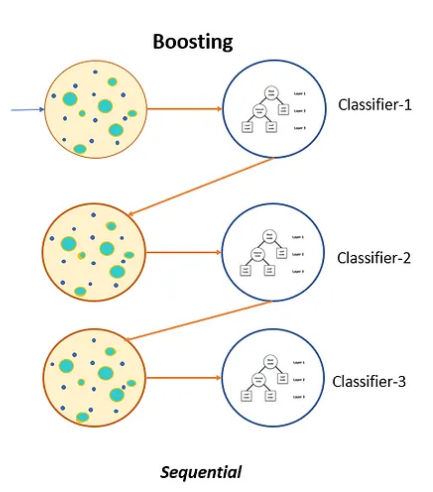

Source: [Gradient Boosting Classifier (GBC)](https://medium.com/swlh/gradient-boosting-trees-for-classification-a-beginners-guide-596b594a14ea).

However, we can see the top 3 hyperparameter for our best model as follows.

In [114]:
pd.DataFrame(result_gbc_smote_2).sort_values(by='mean_test_score', ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,300.922683,6.639282,0.337313,0.029097,0.005,7,400,"{'model__learning_rate': 0.005, 'model__max_depth': 7, 'model__n_estimators': 400}",0.489168,0.496321,0.494490,0.459818,0.497627,0.487485,0.014130,1
9,151.281637,2.451886,0.156140,0.015383,0.005,7,200,"{'model__learning_rate': 0.005, 'model__max_depth': 7, 'model__n_estimators': 200}",0.491736,0.499334,0.486957,0.457898,0.501326,0.487450,0.015657,2
18,162.800124,10.348610,0.186964,0.008165,0.01,7,200,"{'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 200}",0.490934,0.495658,0.492096,0.458947,0.497627,0.487053,0.014257,3


To see the model performance in test set, we need to fit the model and below is the result

In [115]:
best_model = grid_search_gbc_smote_2.best_estimator_
best_model.fit(x_train, y_train)

y_pred_bm3 = best_model.predict(x_test)
print('Classification Report \n',classification_report(y_test, y_pred_bm3))
print('F1 Score',f1_score(y_test, y_pred_bm3))
print('Accuracy',accuracy_score(y_test, y_pred_bm3))

Classification Report 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6568
           1       0.44      0.52      0.48       841

    accuracy                           0.87      7409
   macro avg       0.69      0.72      0.70      7409
weighted avg       0.88      0.87      0.88      7409

F1 Score 0.48117839607201307
Accuracy 0.871642596841679


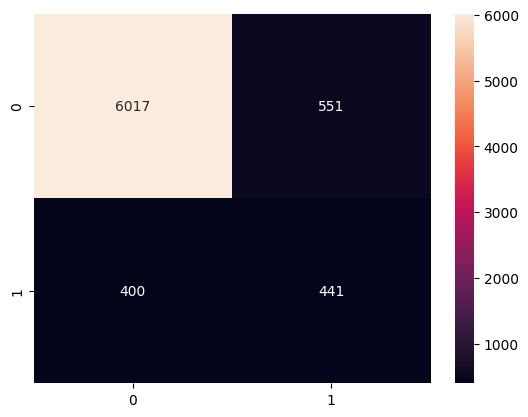

In [116]:
sns.heatmap(confusion_matrix(y_test, y_pred_bm3), annot=True, fmt='.4g');

From the confusion matrix, the comparison with our first benchmark model is as follows. The data is stable based on previous comparison on the training dataset which produced a F1 score of 48.7%

- False Positive: 492 --> 551
- False Negative: 433 --> 400
- True Positive: 408 --> 441
- True Negative: 6076 --> 6017
- F1 score: 46.8% --> 48.1%

We can see that our F1 score is already improving, but we get a bigger number for False Positives and reduce False Negatives.

> ## Feature Importance

Feature importance is used to see which variable contributes more in our model.

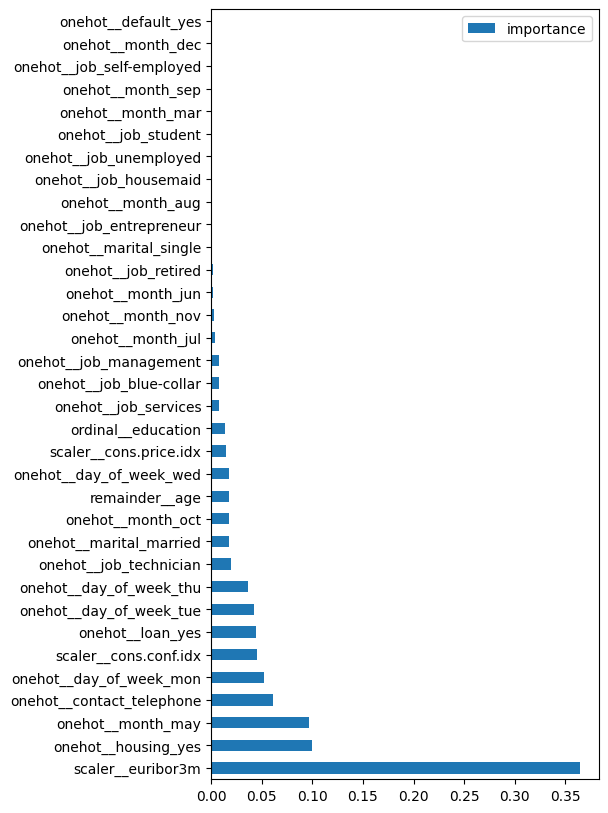

In [117]:
data = grid_search_gbc_smote_2.best_estimator_.steps[-1][1].feature_importances_.tolist()
col = x_train_prep.columns.tolist()
df_importance = pd.DataFrame(data=data, index=col, columns=["importance"]).sort_values(
    by="importance", ascending=False
)
df_importance.plot(kind="barh", figsize=(5,10));

From the chart we can see that the top 3 features are:
1. Euribor3m
1. Have housing
1. Called in May

These features are the one impacting our model accuracy. In further model improvement, we can prioritize the higher importance variables for our model and taking out the variables that matters less. This can help our model to be more time efficient.

> ## Predict Probability Best Model

While our model is a classification model, we can get the positive (deposit) and negative (no deposit) probability to further determine our marketing strategy.

We can utilize predict_proba to get each class' probability and build a probability based recommendation.

In [118]:
best_model = grid_search_gbc_smote_2.best_estimator_
best_model.fit(x_train, y_train)

prob = best_model.predict_proba(x_test)
df_prob = pd.DataFrame(prob, columns=best_model.classes_)
df_prob.columns = ["no deposit", "deposit"]
df_prob

,no deposit,deposit
0,0.811117,0.188883
1,0.716386,0.283614
2,0.774884,0.225116
3,0.806712,0.193288
4,0.773872,0.226128
...,...,...
7404,0.814253,0.185747
7405,0.759004,0.240996
7406,0.759564,0.240436
7407,0.833864,0.166136


In [119]:
y_pred_series = pd.Series(y_pred_bm3, name='y_pred')
df_result = pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True), y_pred_series, df_prob], axis=1)
df_result.columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'y_actual', 'y_pred', 'prob 0', 'prob 1']
df_result['pred_result']=np.where(df_result['y_actual']==df_result['y_pred'], 'true', 'false')
df_result

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m,y_actual,y_pred,prob 0,prob 1,pred_result
0,54,admin.,married,university.degree,no,yes,no,cellular,aug,thu,93.444,-36.1,4.968,0,0,0.811117,0.188883,true
1,33,blue-collar,married,basic.4y,no,no,no,cellular,may,tue,92.893,-46.2,1.291,0,0,0.716386,0.283614,true
2,56,admin.,married,university.degree,no,no,no,cellular,aug,wed,93.444,-36.1,4.964,1,0,0.774884,0.225116,false
3,47,management,married,university.degree,no,no,no,cellular,nov,mon,93.200,-42.0,4.191,0,0,0.806712,0.193288,true
4,38,technician,married,professional.course,no,yes,no,cellular,aug,tue,93.444,-36.1,4.963,0,0,0.773872,0.226128,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,36,technician,married,professional.course,no,yes,no,cellular,aug,thu,93.444,-36.1,4.964,0,0,0.814253,0.185747,true
7405,39,technician,married,professional.course,no,yes,no,cellular,jul,wed,93.918,-42.7,4.962,0,0,0.759004,0.240996,true
7406,37,technician,married,professional.course,no,yes,no,cellular,aug,fri,93.444,-36.1,4.963,0,0,0.759564,0.240436,true
7407,28,blue-collar,married,basic.6y,no,yes,no,telephone,jul,fri,93.918,-42.7,4.963,0,0,0.833864,0.166136,true


> ## Model Limitation: Error Prediction

We observe that our model is not 100% accurate, thus having incorrect prediction is expected. Below are the ranges in which our model failed to predict the correct outcome as one of our **model's limitation**.

In [120]:
df_result_false = df_result[df_result['pred_result']=='false'][['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m']]
display(df_result_false.describe(), df_result_false.describe(include='O'))

,age,cons.price.idx,cons.conf.idx,euribor3m
count,951.000000,951.000000,951.000000,951.000000
mean,40.944269,93.220189,-39.729232,2.048531
std,13.273323,0.678841,6.492707,1.672706
min,18.000000,92.201000,-50.800000,0.635000
25%,31.000000,92.843000,-46.200000,0.873000
50%,37.000000,93.075000,-40.800000,1.281000
75%,49.000000,93.918000,-34.800000,4.076000
max,91.000000,94.767000,-26.900000,5.000000


,job,marital,education,default,housing,loan,contact,month,day_of_week
count,951,951,951,951,951,951,951,951,951
unique,11,3,7,1,2,2,2,10,5
top,admin.,married,university.degree,no,yes,no,cellular,may,mon
freq,271,526,359,951,549,805,804,170,214


In [121]:
cfDesc = []
for i in df_result_false.columns:
    cfDesc.append(
        [
            i,
            df_result_false[i].dtypes,
            df_result_false[i].nunique(),
            df_result_false[i].drop_duplicates().values
        ]
    )

pd.set_option("display.max_colwidth", 0)
pd.DataFrame(data=cfDesc, columns=["features", "DataType","Unique","Data"])

,features,DataType,Unique,Data
0,age,int64,67,"[56, 25, 37, 36, 48, 33, 74, 34, 30, 43, 32, 40, 42, 31, 58, 64, 28, 26, 59, 65, 38, 23, 54, 21, 27, 60, 39, 50, 35, 52, 46, 71, 53, 44, 63, 77, 24, 20, 61, 29, 80, 41, 57, 22, 55, 47, 72, 66, 91, 18, 70, 88, 45, 67, 79, 73, 81, 62, 68, 49, 69, 83, 76, 78, 51, 82, 75]"
1,job,object,11,"[admin., services, technician, blue-collar, retired, self-employed, management, student, unemployed, entrepreneur, housemaid]"
2,marital,object,3,"[married, single, divorced]"
3,education,object,7,"[university.degree, high.school, basic.4y, basic.6y, basic.9y, professional.course, illiterate]"
4,default,object,1,[no]
5,housing,object,2,"[no, yes]"
6,loan,object,2,"[no, yes]"
7,contact,object,2,"[cellular, telephone]"
8,month,object,10,"[aug, may, jun, mar, oct, apr, jul, nov, sep, dec]"
9,day_of_week,object,5,"[wed, fri, mon, tue, thu]"


The model incorrectly predict on the following ranges:
1. Age: 18 - 91
1. Cons.price.idx: 92.2 - 94.76
1. Cons.conf.idx: (-50.8) - (-26.9)
1. Euribor3m: 0.635 - 5
1. Nr.employed: 4963.6 - 5228.1
1. Job: 11 categories as above
1. Marital: 3 categories as above
1. Education: 7 categories as above
1. Default: 1 category as above
1. Housing, loan, contact: 2 categories as above
1. Month: 10 categories as above
1. Day_of_week: 5 categories as above

> ## Strategy based on Model Probability

We focus on F1 scores to allow marketing team flexibility to choose between defensive (reduce cost) or aggresive (increase revenue) strategy. Using probability, we can use specific ranges for positive class to determine strategy if we're going to increase revenue. If the team decides to pursue a cost efficiency method, it is still available as our initial prediction is based on yes/no.

1. Reduce cost
	- < 50%: No call
	- '>= 50%: Call

1. Increase revenue
	- < 25%: No call 
		- Probability of accepting is too small
	- 25% - 50%: Call + credit card bundling + admin fee waiver 
		- Giving out extra things to customer, but need to ensure the gift is based on the customer's deposit value since gift itself is actually a cost
	- 50% - 75%: Call + credit card bundling 
		- Alike the 2nd level, but we're giving less benefit since the probability percentage is increasing and customer is more likely to put deposit
	- '>= 75%: Call
		- Customer is already likely to put deposit, no need for extra cost to persuade them.

Marketing benefits and actions can be be combined with various probability percentage. When we have account value data, we can add the parameter of bonus benefit based on the potential deposit value.

In [122]:
df_result

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m,y_actual,y_pred,prob 0,prob 1,pred_result
0,54,admin.,married,university.degree,no,yes,no,cellular,aug,thu,93.444,-36.1,4.968,0,0,0.811117,0.188883,true
1,33,blue-collar,married,basic.4y,no,no,no,cellular,may,tue,92.893,-46.2,1.291,0,0,0.716386,0.283614,true
2,56,admin.,married,university.degree,no,no,no,cellular,aug,wed,93.444,-36.1,4.964,1,0,0.774884,0.225116,false
3,47,management,married,university.degree,no,no,no,cellular,nov,mon,93.200,-42.0,4.191,0,0,0.806712,0.193288,true
4,38,technician,married,professional.course,no,yes,no,cellular,aug,tue,93.444,-36.1,4.963,0,0,0.773872,0.226128,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,36,technician,married,professional.course,no,yes,no,cellular,aug,thu,93.444,-36.1,4.964,0,0,0.814253,0.185747,true
7405,39,technician,married,professional.course,no,yes,no,cellular,jul,wed,93.918,-42.7,4.962,0,0,0.759004,0.240996,true
7406,37,technician,married,professional.course,no,yes,no,cellular,aug,fri,93.444,-36.1,4.963,0,0,0.759564,0.240436,true
7407,28,blue-collar,married,basic.6y,no,yes,no,telephone,jul,fri,93.918,-42.7,4.963,0,0,0.833864,0.166136,true


In [123]:
def leveling(x):
    if x < 0.25:
        leveling_result = 'no call'
    elif 0.25 <= x < 0.5:
        leveling_result = 'call + credit card bundling + admin fee waiver'
    elif 0.5 <= x < 0.75:
        leveling_result = 'call + credit card bundling '
    elif x >= 0.75:
        leveling_result = 'call'
    return leveling_result

df_result['strategy_1'] = np.where(df_result['y_pred']==1, 'call', 'no call')
df_result['strategy_2'] = df_result['prob 1'].apply(leveling)
df_result

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m,y_actual,y_pred,prob 0,prob 1,pred_result,strategy_1,strategy_2
0,54,admin.,married,university.degree,no,yes,no,cellular,aug,thu,93.444,-36.1,4.968,0,0,0.811117,0.188883,true,no call,no call
1,33,blue-collar,married,basic.4y,no,no,no,cellular,may,tue,92.893,-46.2,1.291,0,0,0.716386,0.283614,true,no call,call + credit card bundling + admin fee waiver
2,56,admin.,married,university.degree,no,no,no,cellular,aug,wed,93.444,-36.1,4.964,1,0,0.774884,0.225116,false,no call,no call
3,47,management,married,university.degree,no,no,no,cellular,nov,mon,93.200,-42.0,4.191,0,0,0.806712,0.193288,true,no call,no call
4,38,technician,married,professional.course,no,yes,no,cellular,aug,tue,93.444,-36.1,4.963,0,0,0.773872,0.226128,true,no call,no call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,36,technician,married,professional.course,no,yes,no,cellular,aug,thu,93.444,-36.1,4.964,0,0,0.814253,0.185747,true,no call,no call
7405,39,technician,married,professional.course,no,yes,no,cellular,jul,wed,93.918,-42.7,4.962,0,0,0.759004,0.240996,true,no call,no call
7406,37,technician,married,professional.course,no,yes,no,cellular,aug,fri,93.444,-36.1,4.963,0,0,0.759564,0.240436,true,no call,no call
7407,28,blue-collar,married,basic.6y,no,yes,no,telephone,jul,fri,93.918,-42.7,4.963,0,0,0.833864,0.166136,true,no call,no call


Initial dataset result

In [149]:
df_result['y_actual'].value_counts()

y_actual
0    6568
1    841 
Name: count, dtype: int64

In [ ]:
df_result['y_actual'].value_counts()

For cost saving strategy

In [124]:
df_result['strategy_1'].value_counts()

strategy_1
no call    6417
call       992 
Name: count, dtype: int64

For maximizing revenue strategy

In [125]:
df_result['strategy_2'].value_counts()

strategy_2
no call                                           4866
call + credit card bundling + admin fee waiver    1551
call + credit card bundling                       520 
call                                              472 
Name: count, dtype: int64

Need further analysis on the cost-benefit. By far, since the minimum deposit is EUR 2500, the bundling and fee waiver shouldn't be bigger than the min. deposit.

> ## Saving Best Model

In [151]:
import pickle

filename = 'model_gbc_smote_v22.sav'
pickle.dump(grid_search_gbc_smote_2.best_estimator_, open(filename,'wb'))

> ## Use Best Model

We are going to test our model with dummy data

In [152]:
load_model = pickle.load(open('model_gbc_smote_v22.sav', "rb"))

In [129]:
def result_call(x):
    x_percentage = (x*100).round(2)
    print('Deposit class probability: ', str(x_percentage).strip("[]"), '%')
    if x < 0.25:
        print("No call at all, risk of rejection too big")
    elif 0.25 <= x < 0.5:
        print("Option 1: No call - to focus reduce cost")
        print("Option 2: Call with credit card bundling and admin fee waiver - to focus maximize revenue")
    elif 0.5 <= x < 0.75:
        print("Option 1: No call - to focus reduce cost")
        print("Option 2: Call with credit card bundling - to focus maximize revenue")
    elif x >= 0.75:
        print("Call, without bundling package")

In [133]:
df_test = pd.DataFrame({
    'age' : [25], 
    'job' : ['technician'], 
    'marital' : ['single'], 
    'education' : ['university.degree'],
    'default' : ['no'] ,
    'housing' : ['no'], 
    'loan' : ['no'], 
    'contact' : ['cellular'],
    'month' : ['jun'], 
    'day_of_week' : ['mon'], 
    'cons.price.idx' : [93.749], 
    'cons.conf.idx' : [-36.4], 
    'euribor3m' : [4.857],
    })

print("Potential Customer Data")
display(df_test)

class_1 = load_model.predict_proba(df_test)[:,1]
result_call(class_1)

Potential Customer Data


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
0,25,technician,single,university.degree,no,no,no,cellular,jun,mon,93.749,-36.4,4.857


Deposit class probability:  31.85 %
Option 1: No call - to focus reduce cost
Option 2: Call with credit card bundling and admin fee waiver - to focus maximize revenue


In [145]:
df_test = pd.DataFrame({
    'age' : [50], 
    'job' : ['entrepreneur'], 
    'marital' : ['married'], 
    'education' : ['university.degree'],
    'default' : ['no'] ,
    'housing' : ['yes'], 
    'loan' : ['no'], 
    'contact' : ['cellular'],
    'month' : ['aug'], 
    'day_of_week' : ['fri'], 
    'cons.price.idx' : [92.379], 
    'cons.conf.idx' : [-38.3], 
    'euribor3m' : [0.8]
    })

print("Potential Customer Data")
display(df_test)

class_1 = load_model.predict_proba(df_test)[:,1]
result_call(class_1)

Potential Customer Data


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
0,50,entrepreneur,married,university.degree,no,yes,no,cellular,aug,fri,92.379,-38.3,0.8


Deposit class probability:  74.83 %
Option 1: No call - to focus reduce cost
Option 2: Call with credit card bundling - to focus maximize revenue


> ## Model Limitation: Variable Error

In [153]:
df_test = pd.DataFrame({
    'age' : [40], 
    'job' : ['housewife'], 
    'marital' : ['married'], 
    'education' : ['professional.course'],
    'default' : ['no'] ,
    'housing' : ['yes'], 
    'loan' : ['no'], 
    'contact' : ['cellular'],
    'month' : ['mar'], 
    'day_of_week' : ['thu'], 
    'cons.price.idx' : [60], 
    'cons.conf.idx' : [10], 
    'euribor3m' : [6],
    })

print("Potential Customer Data")
display(df_test)

class_1 = load_model.predict_proba(df_test)[:,1]
result_call(class_1)

Potential Customer Data


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,cons.price.idx,cons.conf.idx,euribor3m
0,40,housewife,married,professional.course,no,yes,no,cellular,mar,thu,60,10,6


Deposit class probability:  19.04 %
No call at all, risk of rejection too big


As seen above, our model isn't able to predict since the job 'housewife' isn't available in our training dataset. The model is able to predict but is not reliable at all since there's no housewife data in the original dataset.Thus, the model is limited to only predict the categorical variables available in the original training dataset.

Further modeling should be needed if there's any update on the actual data to predict.

> ## Conclusion

1. The customer profile most likely to respond favorably to deposit marketing campaigns encompasses students, individuals living independently, those with lower levels of education, a clean credit history, individuals with active housing and personal loans, those reached via mobile communication and individuals under 20 years old. These findings indicate that younger, financially active individuals without credit complications and with an established bank relationship (such as through loans) are more inclined to consider deposit offers. Moreover, the preference for mobile communication underscore the importance of personalized and extended interactions in marketing strategies targeting this demographic. These insights can assist the bank in fine-tuning its targeting and messaging approaches to effectively connect with and captivate potential deposit customers.To effectively connect with and captivate potential deposit customers, a strategic approach must be taken, starting with defining the target market and utilizing both traditional and digital marketing channels, offering competitive products and services alongside prioritizing superior customer service are essential elements for success. Source: [Connect with customer](https://fastercapital.com/questions/How-to-Market-Your-Bank-to-Attract-Customers.html)

2. Economic conditions significantly influence customers' decisions on depositing funds. Stable employment rates and lower inflation foster confidence in long-term deposits, while higher consumer confidence encourages investment. Low interest rates attract more customers to deposits, whereas economic downturns shift priorities towards immediate financial stability over long-term investments. Overall, stable economic indicators enhance the appeal of deposits, while uncertainty may decrease interest as individuals focus on short-term financial security. To overcome economic challenges, two strategies are prepared: first, to reduce costs, and second, to increase revenue. In difficult economic conditions, bank marketing can utilize the cost reduction strategy, while in favorable economic conditions, they can focus on increasing revenue.Furthermore, these strategies will be elaborated upon in the following conclusion.

3. The model with the highest F1 score achieved 46.8%, indicating moderate effectiveness in reducing both False Positives and False Negatives. By employing Gradient Boosting Classifier (GBC) with Synthetic Minority Over-sampling Technique (SMOTE), the F1 score improved to 48.8%, with specific hyperparameters: learning rate of 0.005, max depth of 7, and 300 estimators. Despite the improvement, the model resulted in an increase in False Positives while reducing False Negatives compared to the benchmark model. Gradient Boosting Classifier (GBC) is machine learning algorithm that combines multiple weak learners, typically decision trees, to create a strong predictive model. It starts by building an initial weak learner and then sequentially builds additional models to correct the errors of the previous ones. Each new model focuses on predicting the errors made by the previous models. Through this iterative process, GBC gradually improves its predictive accuracy until it reaches a stopping criterion. Finally, the predictions from all weak learners are combined to make the final prediction. This approach enables GBC to effectively learn complex patterns in the data and make accurate predictions.<br>

4. With the model, we can potentially save up cost and maximize growth as of the following simulation:<br>

> Cost Saving Strategy:<br>
- Total marketing cost without ML:
    - Marketing cost per customer: EUR 1.07 <br>
    - Total number of clients: 7,409
    - Total marketing cost: EUR 1.07 * 7,409 = EUR 7,928
- Cost Reduction with Cost-Saving Strategy:
    - Number of clients assigned to the cost-saving strategy: 992 (high probability to put deposit)
    - Marketing cost per customer: EUR 1.07
    - Total cost reduction: EUR 1.07 * 992 = EUR 1,061

- Total saving = Total marketing cost without ML - Cost reduction with cost-saving strategy
    - **Total saving = EUR 7928 - EUR 1061 = EUR 6867**
    
So, by implementing the cost-saving strategy, the total saving is **EUR 6867**.

> Maximize Revenue Strategy<br>
- Total revenue without ML:
	- Total number of client deposit: 841
	- Min. revenue of deposit per customer: EUR 2,501.25
	- Total revenue: 841 * EUR 2,501.25 = EUR 2,103,551 
- Total potential revenue with leveled probability strategy:
	- Min. revenue of deposit per customer: EUR 2,501.25
	- Marketing cost per customer: EUR 1.07
	- Credit card cost bundling: EUR 250 (min. credit card limit)
	- Waiver fee cost: EUR 70
	- Total revenue "no call": EUR 0
	- Total revenue "call + credit card + admin fee waiver": (1551 * EUR 2,501.25) - {1551 * (EUR 1.07 + 250 + 70} = EUR 3,381,459
	- Total revenue "call + admin fee waiver": (520 * EUR 2,501.25) - {520 * (EUR 1.07 + 70} = EUR 1,263,694
	- Total revenue "call": (472 * EUR 2,501.25) - (472 * EUR 1.07) = EUR 1,180,085
- Total potential revenue growth = Total with leveled probability strategy - Total revenue without ML
    - **Total growth = (EUR 3,381,459 + 1,263,694 + 1,180,085) - EUR 2,103,551 = EUR 3,721,687 (70% growth)**

So, by implementing the maximize revenue strategy, the total potential growth is **EUR 3,721,687** or **70% growth**

5. The machine learning model helps the marketing team plan their strategies more effectively. But it's important to use it wisely, especially before contacting clients. The model can predict how customers might respond to different approaches, so it's best to use it when planning how to reach out to clients. By using the model's insights, the marketing team can improve how they target, message, and allocate resources for their campaigns. 

6. The model may encounter challenges when predicting outcomes for individuals within certain age ranges (18 to 91 years old) and economic indicators such as Emp.var.rate (-1.37 to 1.4), Cons.price.idx (92 to 94.76), Cons.conf.idx (-50.8 to -26.9), Euribor3m (0.635 to 5), and Nr.employed (4963.6 to 5228.1). Additionally, the absence of certain categorical variables that were not included in the dataset could also present limitations for the model's predictions, potentially leading to inaccuracies. 

Source:
- [Min credit card limit](https://www.seb.ee/en/private/cards/credit-card-predetermined-repayment)
- [Monthly handling](https://www.portugalbuyersagent.com/banking-in-portugal/#:~:text=Most%20Portuguese%20bank%20accounts%20charge,such%20as%20student%20bank%20accounts).

> ## Recommendation

In the recommendations section, several key areas for improvement and expansion emerge from the analysis. It will be separated into two aspects: recommendations needed for internal use, which represent recommendations we believe can be applied towards the dataset and model, as well as a section to further elaborate potential external uses, meaning recommendations that we believe the marketing team could use while incorporating our model.

Firstly, enhancing the model's performance is paramount. Incorporating advanced algorithms, refining feature engineering and exploring more hyperparameter tunings could significantly bolster predictive accuracy. Sadly, due to the time constraints our team was not able to touch into the problems above. Secondly, addressing data quality issues, particularly pertaining to aspects such as the amount of deposits currently held in their account or elements such as their income, would definitely help ensure the robustness of the model. For example, when we have account value data, we can incorporate parameters for bonus benefits and approaches based on potential deposits. Investing in data cleansing and augmentation processes can mitigate biases and improve overall model efficacy. Additionally, leveraging faster computing devices is imperative to expedite the modeling process, thereby enhancing operational efficiency. Exploring a broader range of hyperparameters through systematic tuning methodologies could further optimize model performance. From our experience and technological resources, we had a relatively long wait in regards to tuning, so to potentially improve such long wait times, we believe investments in better computing devices would be beneficial.

Secondly, in terms of marketing strategies for future campaigns, diversification of outreach other than calling is advised. Implementing a multifaceted approach encompassing referral programs, offline promotions, and gift programs (electronic devices) can broaden outreach and engagement for the company. Furthermore, incorporating a lucky draw element could incentivize customer participation and drive brand visibility.

From a business perspective, with our current model, we can predict up to an 87% accuracy rate and an F1 score of 48.7%. Utilizing our model, we concluded that we currently have 441 targets that are true positive. In other words, out of all the instances that are actually positive, the model correctly predicted 441 of them. In essence, this means that we can focus on these groups of people to ensure that they become loyal customers for the bank. Moreover, by identifying the true negatives, we can emphasize the impact on reducing operational costs, such as manpower management, and quantify the accuracy probability.

We are focusing on the F1 score to allow the marketing team flexibility to choose a defensive (reduce cost) or aggressive (increase revenue) strategy. Using probability, we can use specific ranges for the positive class to determine strategy if the team wishes to increase revenue. If the team decides to pursue a cost-efficient method, it is still available as our initial prediction is based on yes/no.

1. Reduce cost
	- < 50%: No call
	- '>= 50%: Call
1. Increase revenue
	- < 25%: No call 
		- Probability of accepting is too small
	- 25% - 50%: Call + credit card bundling + admin fee waiver 
		- Giving out extra things to customer, but need to ensure the gift is based on the customer's deposit value since gift itself is actually a cost
	- 50% - 75%: Call + credit card bundling 
		- Alike the 2nd level, but we're giving less benefit since the probability percentage is increasing and customer is more likely to put deposit
	- '>= 75%: Call
		- Customer is already likely to put deposit, no need for extra cost to persuade them.


We understand that these marketing approaches and benefits will be determined by the marketing team, and all these actions can be intertwined and mixed. However, we believe that distributing merchandise for extra advertising and branding purposes would benefit the bank for future endeavors.

In summary, with some improvements regarding the datasets and model, along with the probability groupings we have established, the bank will surely be able to enhance their campaigns and benefit from the increased efficiency, effectiveness, and hopefully revenue our model can provide.

 

Source:
- [Types of Strategies to Increase Bank Deposits](https://www.tidalcommerce.com/learn/increase-bank-deposits)
- [Success in Bank Refferal Programs](https://www.moneythor.com/2023/11/10/referral-programs-in-banking/).
- [Bundling Programmes in Bank](https://www.suntecgroup.com/articles/the-bundling-dilemma-effective-bundling-strategies-for-modern-banking/).